# Regresor para estimar el espaciamiento espectral

- [x] Agregar la métrica de RMSE.
- [x] Cambiar las gráficas para que se distingan por marcadores y solo con los puntos discretos.
- [x] Probar con los datos GKM.
- [x] Cambiar ReLu por Swish.
- [x] Graficar la función de pérdida.
- [x] Variar el número de capas ocultas (1 a 4 capas, (relu), (relu, sigmoid), (relu, tanh, sigmoid), (relu, relu, tanh, sigmoid).
- [x] Hacer una prueba con la función de pérdida MSE, (RMSE).
- [x] Recortar el historial de peŕdida (Apróximadamente en 500, para ver el cambio brusco)
- [x] $\mu$ (eje y) vs. hidden layers number (eje x), para todos los escenarios (B2B, 0dBm, 9dBm), 3 gráficas (una para cada métrica) 
- [x] Para la evaluación de la función de pérdida (MSE vs. MAE) cambiar el eje y para usar $\mu$ y el eje x, se separan los escenarios (poner 3 índices y luego cambiarles la apariencia).

In [176]:
# Imports
import sofa
import polars as pl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow.keras as ker

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models, regularizers, Sequential, utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from time import time

## Funciones globales

In [5]:
def calc_once(varname, fn, args):
    """ Calculate a variable only once. """
    if varname not in globals():
        return fn(**args)
    return eval(varname)

### Regresión

In [174]:
def estimation_model(input_dim, layers_props_lst, loss_fn):
    """ Compile a sequential model for regression purposes. """
    model = ker.Sequential()
    # Hidden layers
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(**layer_props, input_dim=input_dim))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Regressor
    model.add(ker.layers.Dense(units=1, activation="linear"))
    
    model.compile(loss=loss_fn, optimizer="adam")
    return model


def estimation_crossvalidation(X, y, n_splits, layer_props, loss_fn, callbacks):
    """ Crossvalidation of an estimation network. """
    # Store initial time
    t0 = time()

    # Scores dict
    scores = {}
    scores["loss"] = []
    scores["mae"] = {"train": [], "test": []}
    scores["r2"] = {"train": [], "test": []}
    scores["rmse"] = {"train": [], "test": []}
    
    # K-fold crossvalidation
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Input variables standarizer
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)

        model = estimation_model(X_train.shape[1], layer_props, loss_fn)
        
        # Save test scalar loss
        if callbacks:
            loss = model.fit(
                X_train, y_train, epochs=5000, batch_size=64, verbose=0, callbacks=callbacks
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        
        # Predict using train values
        predictions_train = model.predict(X_train)
        # Predict using test values
        predictions_test = model.predict(X_test_kf)

        # Dataframe for better visualization
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )

        # MAE
        mae_score_train = mean_absolute_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        mae_score_test = mean_absolute_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # R²
        r2_score_train = r2_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        r2_score_test = r2_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )
         
        # RMSE
        rmse_score_train = mean_squared_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"],
            squared=False
        )
        rmse_score_test = mean_squared_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"],
            squared=False
        )

        # Append to lists
        scores["loss"].append(loss)
        scores["mae"]["train"].append(mae_score_train)
        scores["mae"]["test"].append(mae_score_test)
        scores["r2"]["train"].append(r2_score_train)
        scores["r2"]["test"].append(r2_score_test)
        scores["rmse"]["train"].append(rmse_score_train)
        scores["rmse"]["test"].append(rmse_score_test)
        
    print(f"Time elapsed: {(time() - t0)/60:.2f} minutes")

    return scores


def test_estimation_model(data, n_splits, max_neurons, activations, loss_fn="mean_absolute_error"):
    """ Test a spectral spacing estimation model with given parameters. """
    variables = 17

    # Split variables
    # Variables
    X = np.array(data[:, 0:variables]).T
    # Tags
    y = np.array(data[:, 19:20]).T
    
    # Layer properties
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(layer_props)
    callbacks = [
        EarlyStopping(monitor="loss", patience=100, mode="min", restore_best_weights=True)
    ]
    
    return estimation_crossvalidation(X, y, n_splits, layer_props, loss_fn, callbacks)


def plot_loss(score, end=500):
    """ Plot loss evolution for each k-fold. """
    for k, loss in enumerate(score["loss"]):
        loss_length = len(loss.history["loss"])
        loss_values = loss.history["loss"][:end if loss_length > end else loss_length]
        epoch_values = range(end if loss_length > end else loss_length)
        plt.plot(epoch_values, loss_values, label=f"k = {k+1}")

def plot_losses(scores, scenario, cmp_fn, cmp_values=[], end=500, based_on_index=False):
    """ Plot loss graphics for each scenario. """
    # Handle default cmp_values
    if len(cmp_values) == 0:
        cmp_values = np.zeros(len(scores))
        
    fig_loss = plt.figure(figsize=(16, 3*len(scores)), layout="constrained")
    fig_loss.suptitle(f"{scenario} loss history", size="x-large")
    
    for index, (score, cmps) in enumerate(zip(scores, cmp_values)):
        plt.subplot(len(scores)//2, 2, index + 1)
        plot_loss(score, end=end)
        
        plt.title(cmp_fn(cmps) if not based_on_index else cmp_fn(index))
        
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        
        # Transparent white box black edge legend
        legend = plt.legend(loc="upper right", edgecolor="black")
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 0.01))
        
        plt.grid(True)

def plot_scores(scores, x_values, scenario, score_names, data_type,
                label, xlabel, markers=[], colors=[], based_on_index=False,
                log=False, multiple_points=False, plot_train=True):
    fig_scores = plt.figure(figsize=(16, 6), layout="constrained")
    fig_scores.suptitle(f"{scenario} scores")
    i = 0
    for sn in score_names:
        ax = plt.subplot(1, len(score_names), i+1)
        for dt in data_type:
            if not plot_train and dt == "train":
                continue
            points = [np.average(score[sn][dt]) for score in scores]
            if not multiple_points:
                label_value = ""
                plt.scatter(x_values, points, marker=markers[0 if dt == "train" else 1],
                            label=f"{dt.title()} {label(i)}", s=100)
            else:
                label_value = ""
                points1 = points[::2]
                points2 = points[1::2]
                plt.scatter(x_values, points1, marker=markers[0 if dt == "train" else 1],
                            color=colors[0 if dt == "train" else 1],
                            label=f"{dt.title()} {label(0)}", s=100)
                plt.scatter(x_values, points2, marker=markers[2 if dt == "train" else 3],
                            color=colors[2 if dt == "train" else 3],
                            label=f"{dt.title()} {label(1)}", s=100)
            title = ""
            if sn == "r2":
                title = "R²"
            elif sn == "acc":
                title = "Accuracy"
            else:
                title = sn.upper()
            plt.title(title)
                
        plt.xlabel(xlabel)
        # Adjust logarithmic scale if requested
        if log:
            plt.xscale("log", base=2)
            
        # Make integer xticks if matches}
        if type(x_values[0]) == np.int64:
            ax.set_xticks(x_values)
            
        if type(x_values[0]) == str:
            ax.set_xticks(range(len(x_values)), x_values)
            
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Transparent white box black edge legend
        legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5),
                            edgecolor="black")
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 0.01))

        plt.grid(True)
        i += 1
    plt.show()    
        
def plot_neurons_scores(scores, max_neurons, scenario):
    score_names = ["mae", "r2", "rmse"]
    data_type = ["train", "test"] 
    markers = ["o", "v"]
    
    # Plot loss
    plot_losses(scores, scenario, lambda neurons: f"{neurons} max number of neurons",
                max_neurons, end=500)
    plt.show()
    
    # Plot scores
    plot_scores(scores, max_neurons, scenario, score_names,
                data_type, label=lambda _: "",
                xlabel="Maximum number of neurons", 
                markers=markers, log=True)
    plt.show()

    
def plot_activations_scores(scores, scenario):
    pass
    # score_names = ["mae", "r2", "rmse"]
    # markers = ["^", "8", "*", "X"]
    # data_type = ["train", "test"]
    
    # # Graficar pérdida
    # plot_losses(scores, scenario,
    #             lambda index: f"{'FCM' if index%2 == 0 else 'GKM'} {'ReLu' if index<2 else 'Swish'}",
    #             end=500, based_on_index=True)
    # plt.show()
    
    # # Graficar puntajes
    # fig_scores = plt.figure(figsize=(16, 6), layout="constrained")
    # fig_scores.suptitle(f"{scenario} scores")
    # i = 0
    # for sn in score_names:
    #     plt.subplot(1, len(score_names), i+1)
    #     for dt in data_type:
    #         for j, (score, neurons) in enumerate(zip(scores, max_neurons)):
    #             points = score[sn][dt]

    #             k = np.arange(len(points), dtype = np.uint8) + 1
                 
    #             plt.scatter(k, points, marker=markers[j], 
    #                         label=f"{'FCM' if j%2 == 0 else 'GKM'} {'ReLu' if j<2 else 'Swish'}, µ = {np.mean(points):.3f}",
    #                         s = 100)
                
    #         plt.title(f"{'Train' if dt == 'train' else 'Test'}")
    #         plt.xlabel("k-fold")
    #         plt.xticks(k)
    #         plt.ylabel("MAE" if sn == "mae" else "R²" if sn == "r2" else "RMSE")
    #         ylim = plt.ylim()
    #         plt.ylim(ylim[0], (ylim[1] + (ylim[1] - ylim[0])*0.25))
    #         plt.grid(True)
    #         plt.legend(loc="upper right")
    #         i += 1
    # plt.show()
    
    
def plot_layers_scores(scores, scenario):
    score_names = ["mae", "r2", "rmse"]
    data_type = ["train", "test"]
    markers = ["D", "H"]
    
    # Plot loss
    plot_losses(scores, scenario, lambda hl_n: f"{hl_n} hidden layers", range(1, len(scores) + 1))
    plt.show()
    
    # Plot scores
    plot_scores(scores, np.arange(1, len(scores) + 1, 1, dtype=int),
                scenario, score_names, data_type, label=lambda _: "",
                xlabel="Number of hidden layers", markers=markers)
    plt.show()    
    
def plot_loss_scores(scores, scenario):
    score_names = ["mae", "r2", "rmse"]
    data_type = ["train", "test"]
    markers = ["o", "o", "D", "D"]
    colors = ["gold", "green", "gold", "green"]
    
    # Plot loss
    plot_losses(scores, scenario, 
                lambda index: f"{'MAE' if index%2==0 else 'MSE'} {'B2B' if index<2 else 'optical fiber at ' + ('0' if index<4 else '9') + ' dBm'}",
                based_on_index=True)
            
    # Plot scores
    plot_scores(scores, ["B2B", "0 dBm", "9 dBm"], scenario, score_names,
                data_type, label=lambda index: f"{'MAE' if index%2==0 else 'MSE'}",
                xlabel="Scenario", markers=markers, colors=colors, multiple_points=True,
                based_on_index=True)
    plt.show()    

## Restaurar variables

### Comparación variando el número máximo de neuronas por capa

#### FCM

In [8]:
%store -r scores_FCM_1024_B2B
%store -r scores_FCM_512_B2B 
%store -r scores_FCM_256_B2B
%store -r scores_FCM_128_B2B

%store -r scores_FCM_1024_fiber0
%store -r scores_FCM_512_fiber0
%store -r scores_FCM_256_fiber0
%store -r scores_FCM_128_fiber0

%store -r scores_FCM_1024_fiber9
%store -r scores_FCM_512_fiber9
%store -r scores_FCM_256_fiber9
%store -r scores_FCM_128_fiber9

#### GKM

In [9]:
%store -r scores_GKM_1024_B2B
%store -r scores_GKM_512_B2B 
%store -r scores_GKM_256_B2B
%store -r scores_GKM_128_B2B

%store -r scores_GKM_1024_fiber0
%store -r scores_GKM_512_fiber0
%store -r scores_GKM_256_fiber0
%store -r scores_GKM_128_fiber0

%store -r scores_GKM_1024_fiber9
%store -r scores_GKM_512_fiber9
%store -r scores_GKM_256_fiber9
%store -r scores_GKM_128_fiber9

### Comparación variando la primera función de activación (ReLu vs. Swish)

In [10]:
%store -r scores_FCM_relu_B2B
%store -r scores_GKM_relu_B2B
%store -r scores_FCM_swish_B2B
%store -r scores_GKM_swish_B2B

%store -r scores_FCM_relu_fiber0
%store -r scores_GKM_relu_fiber0
%store -r scores_FCM_swish_fiber0
%store -r scores_GKM_swish_fiber0

%store -r scores_FCM_relu_fiber9
%store -r scores_GKM_relu_fiber9
%store -r scores_FCM_swish_fiber9
%store -r scores_GKM_swish_fiber9

### Comparación variando el número de capas ocultas

In [11]:
%store -r scores_FCM_B2B_1HL
%store -r scores_FCM_B2B_2HL
%store -r scores_FCM_B2B_3HL
%store -r scores_FCM_B2B_4HL

%store -r scores_FCM_fiber0_1HL
%store -r scores_FCM_fiber0_2HL
%store -r scores_FCM_fiber0_3HL
%store -r scores_FCM_fiber0_4HL

%store -r scores_FCM_fiber9_1HL
%store -r scores_FCM_fiber9_2HL
%store -r scores_FCM_fiber9_3HL
%store -r scores_FCM_fiber9_4HL

### Comparación variando la función de pérdida (MAE vs. RMSE)

In [12]:
%store -r scores_FCM_MAE_B2B
%store -r scores_FCM_MSE_B2B

%store -r scores_FCM_MAE_fiber0
%store -r scores_FCM_MSE_fiber0

%store -r scores_FCM_MAE_fiber9
%store -r scores_FCM_MSE_fiber9

## Cargar los datos

### FCM

In [36]:
data_file_FCM = "../Databases/CaractFCM.csv"
df_FCM = pl.read_csv(data_file_FCM, dtypes=[pl.Float64], has_header=False)

# Scenarios split
# Back-to-back (B2B)
df_FCM_B2B = df_FCM[0:987, :]
# 0dBm optical fiber
df_FCM_fiber0 = df_FCM[988:1520, :]
# 9dBm optical fiber
df_FCM_fiber9 = df_FCM[1521:, :]

### GKM

In [37]:
data_file_GKM = "../Databases/CaractGKM.csv"
df_GKM = pl.read_csv(data_file_GKM, dtypes=[pl.Float64], infer_schema_length = 10000, has_header=False)

# Scenarios split
# Back-to-back (B2B)
df_GKM_B2B = df_GKM[0:987, :]

# 0dBm optical fiber
df_GKM_fiber0 = df_GKM[988:1520, :]

# 9dBm optical fiber
df_GKM_fiber9 = df_GKM[1521:, :]

## Comparación variando el número máximo de neuronas por capa

### FCM B2B

In [38]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_B2B = calc_once("scores_FCM_1024_B2B", test_estimation_model, args)

In [39]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_B2B = calc_once("scores_FCM_512_B2B", test_estimation_model, args)

In [40]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_B2B = calc_once("scores_FCM_256_B2B", test_estimation_model, args)

In [41]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_B2B = calc_once("scores_FCM_128_B2B", test_estimation_model, args)

In [42]:
%store scores_FCM_1024_B2B
%store scores_FCM_512_B2B 
%store scores_FCM_256_B2B
%store scores_FCM_128_B2B

Stored 'scores_FCM_1024_B2B' (dict)
Stored 'scores_FCM_512_B2B' (dict)
Stored 'scores_FCM_256_B2B' (dict)
Stored 'scores_FCM_128_B2B' (dict)


#### Gráficas

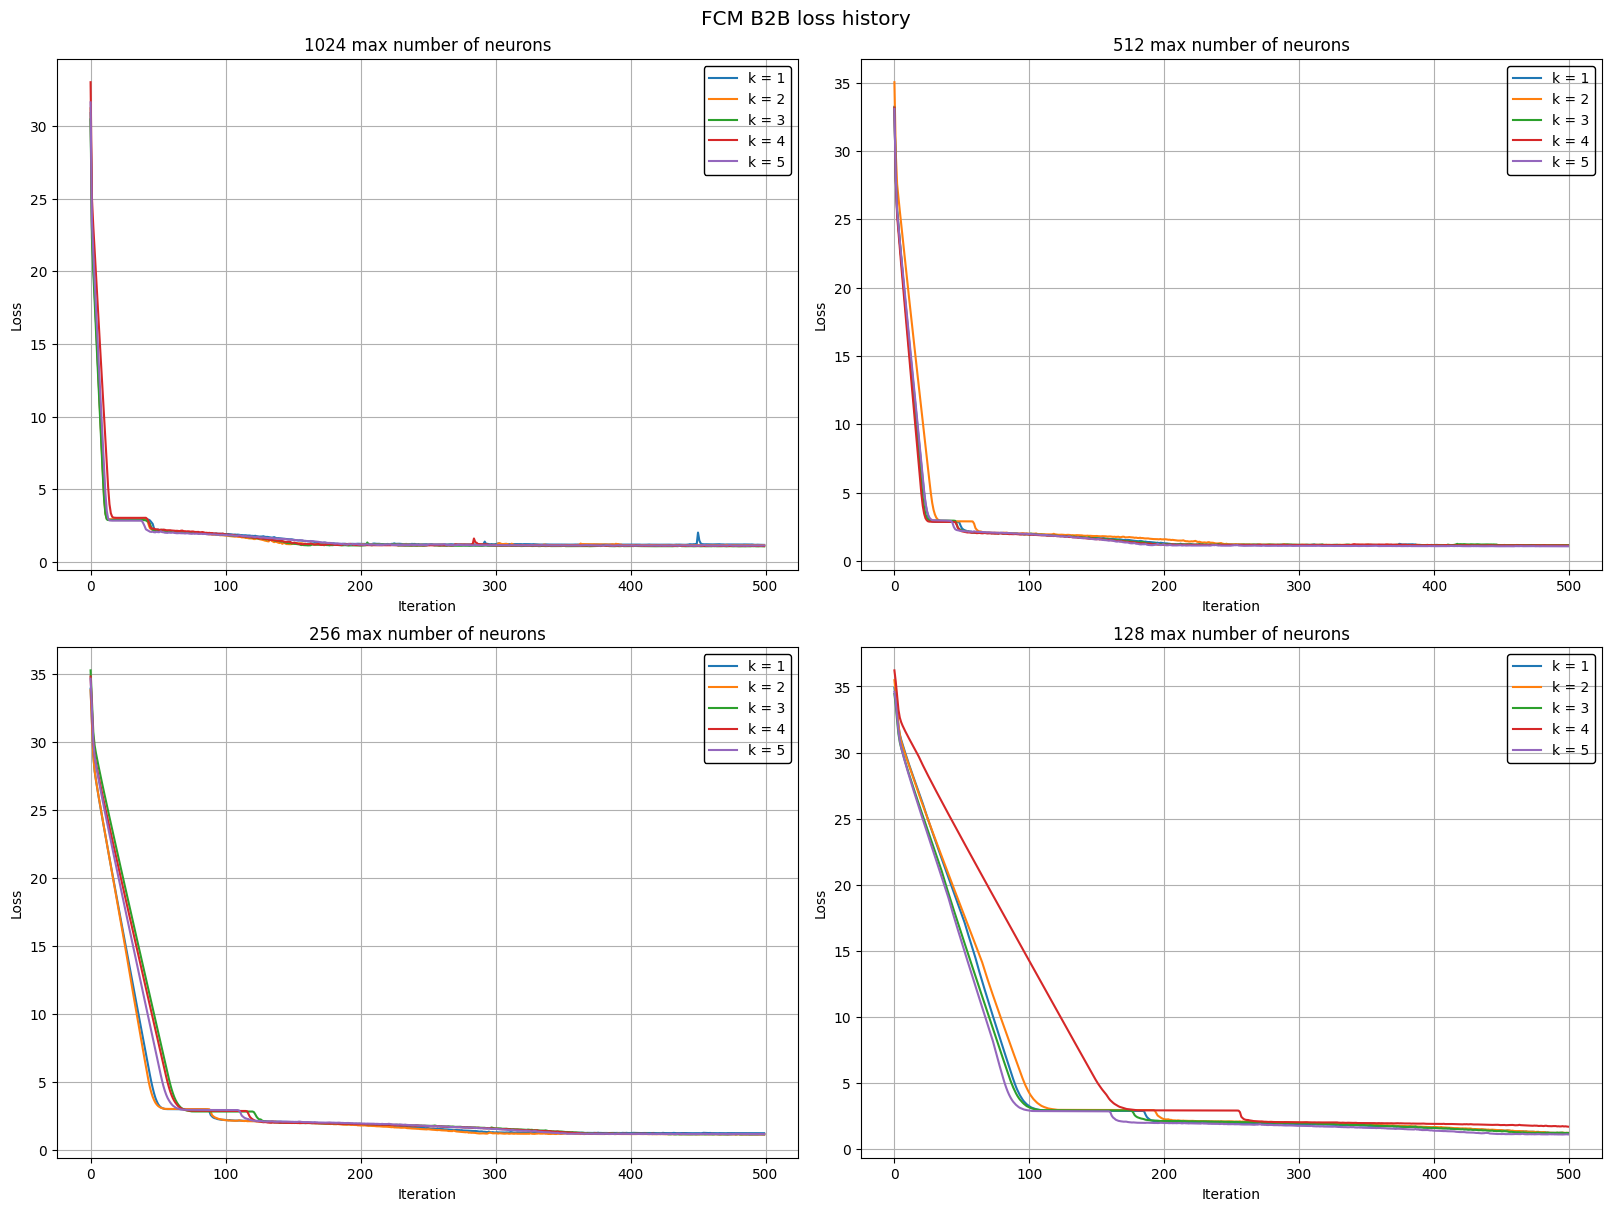

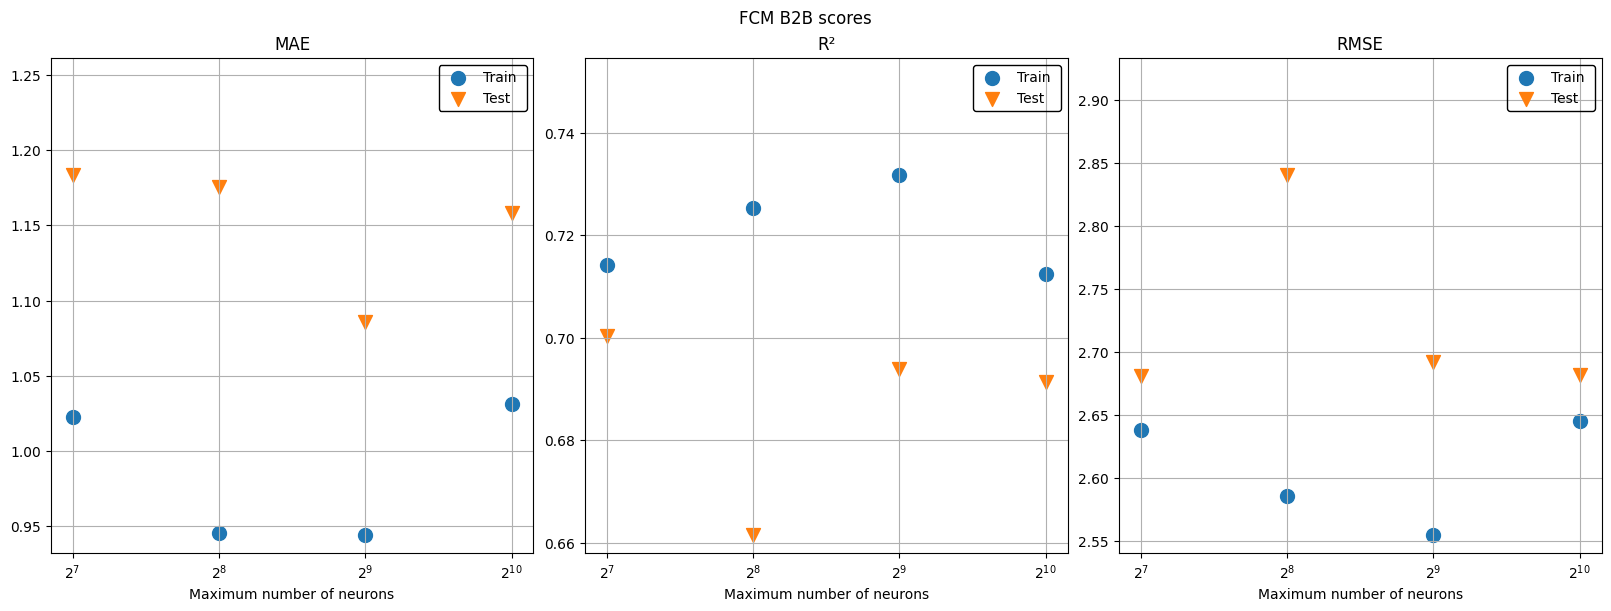

In [43]:
scores = [scores_FCM_1024_B2B, scores_FCM_512_B2B, scores_FCM_256_B2B, scores_FCM_128_B2B]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "FCM B2B")

### FCM con fibra óptica a 0dBm

In [44]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_fiber0 = calc_once("scores_FCM_1024_fiber0", test_estimation_model, args)

In [45]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_fiber0 = calc_once("scores_FCM_512_fiber0", test_estimation_model, args)

In [46]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_fiber0 = calc_once("scores_FCM_256_fiber0", test_estimation_model, args)

In [47]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_fiber0 = calc_once("scores_FCM_128_fiber0", test_estimation_model, args)

In [48]:
%store scores_FCM_1024_fiber0 
%store scores_FCM_512_fiber0 
%store scores_FCM_256_fiber0 
%store scores_FCM_128_fiber0

Stored 'scores_FCM_1024_fiber0' (dict)
Stored 'scores_FCM_512_fiber0' (dict)
Stored 'scores_FCM_256_fiber0' (dict)
Stored 'scores_FCM_128_fiber0' (dict)


#### Gráficas

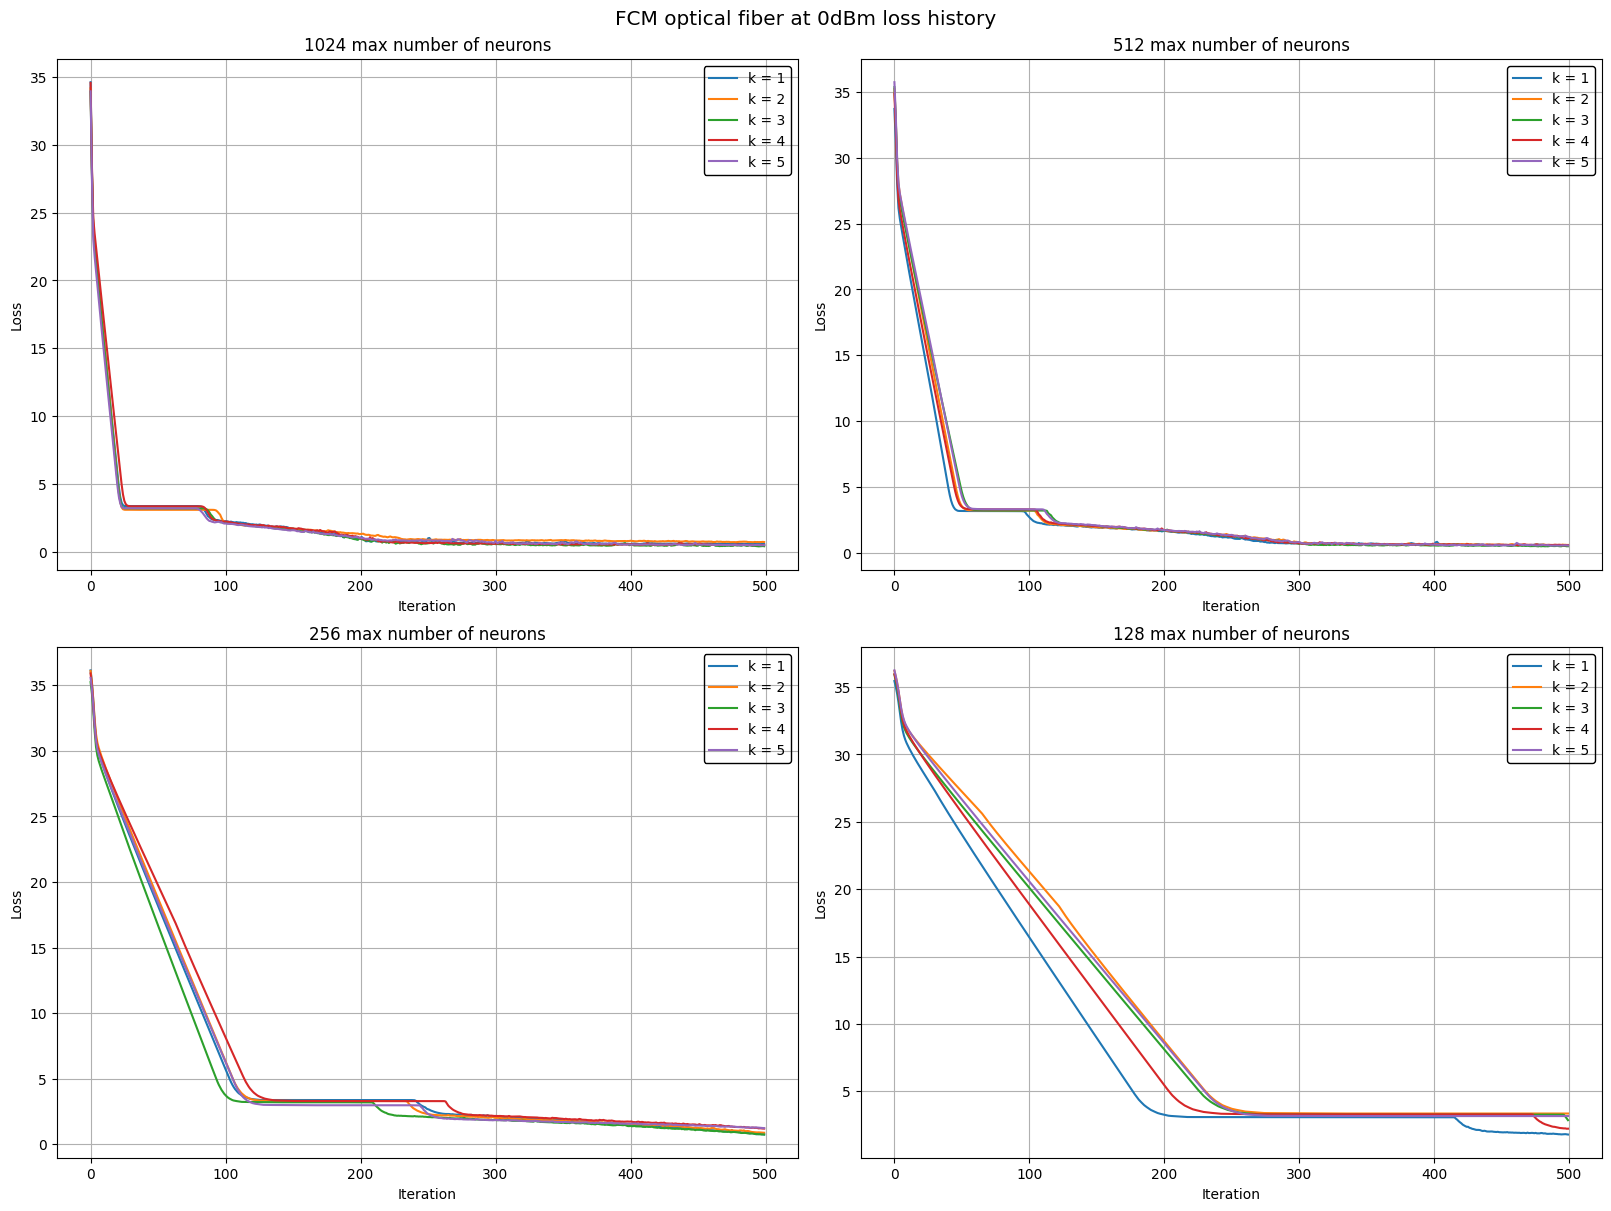

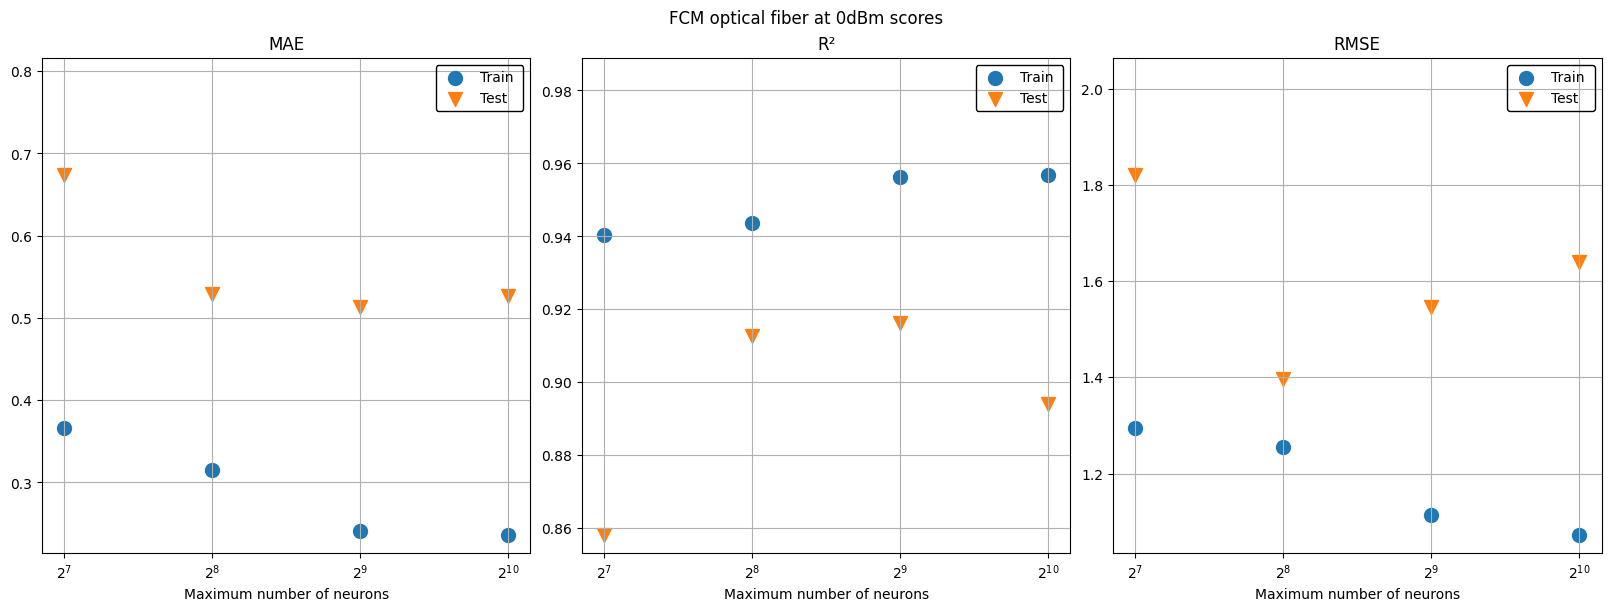

In [49]:
scores = [scores_FCM_1024_fiber0, scores_FCM_512_fiber0, scores_FCM_256_fiber0, scores_FCM_128_fiber0]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, scenario="FCM optical fiber at 0dBm")

### FCM con fibra óptica a 9dBm

In [50]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_fiber9 = calc_once("scores_FCM_1024_fiber9", test_estimation_model, args)

In [51]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_fiber9 = calc_once("scores_FCM_512_fiber9", test_estimation_model, args)

In [52]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_fiber9 = calc_once("scores_FCM_256_fiber9", test_estimation_model, args)

In [53]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_fiber9 = calc_once("scores_FCM_128_fiber9", test_estimation_model, args)

In [54]:
%store scores_FCM_1024_fiber9
%store scores_FCM_512_fiber9 
%store scores_FCM_256_fiber9 
%store scores_FCM_128_fiber9

Stored 'scores_FCM_1024_fiber9' (dict)
Stored 'scores_FCM_512_fiber9' (dict)
Stored 'scores_FCM_256_fiber9' (dict)
Stored 'scores_FCM_128_fiber9' (dict)


#### Gráficas

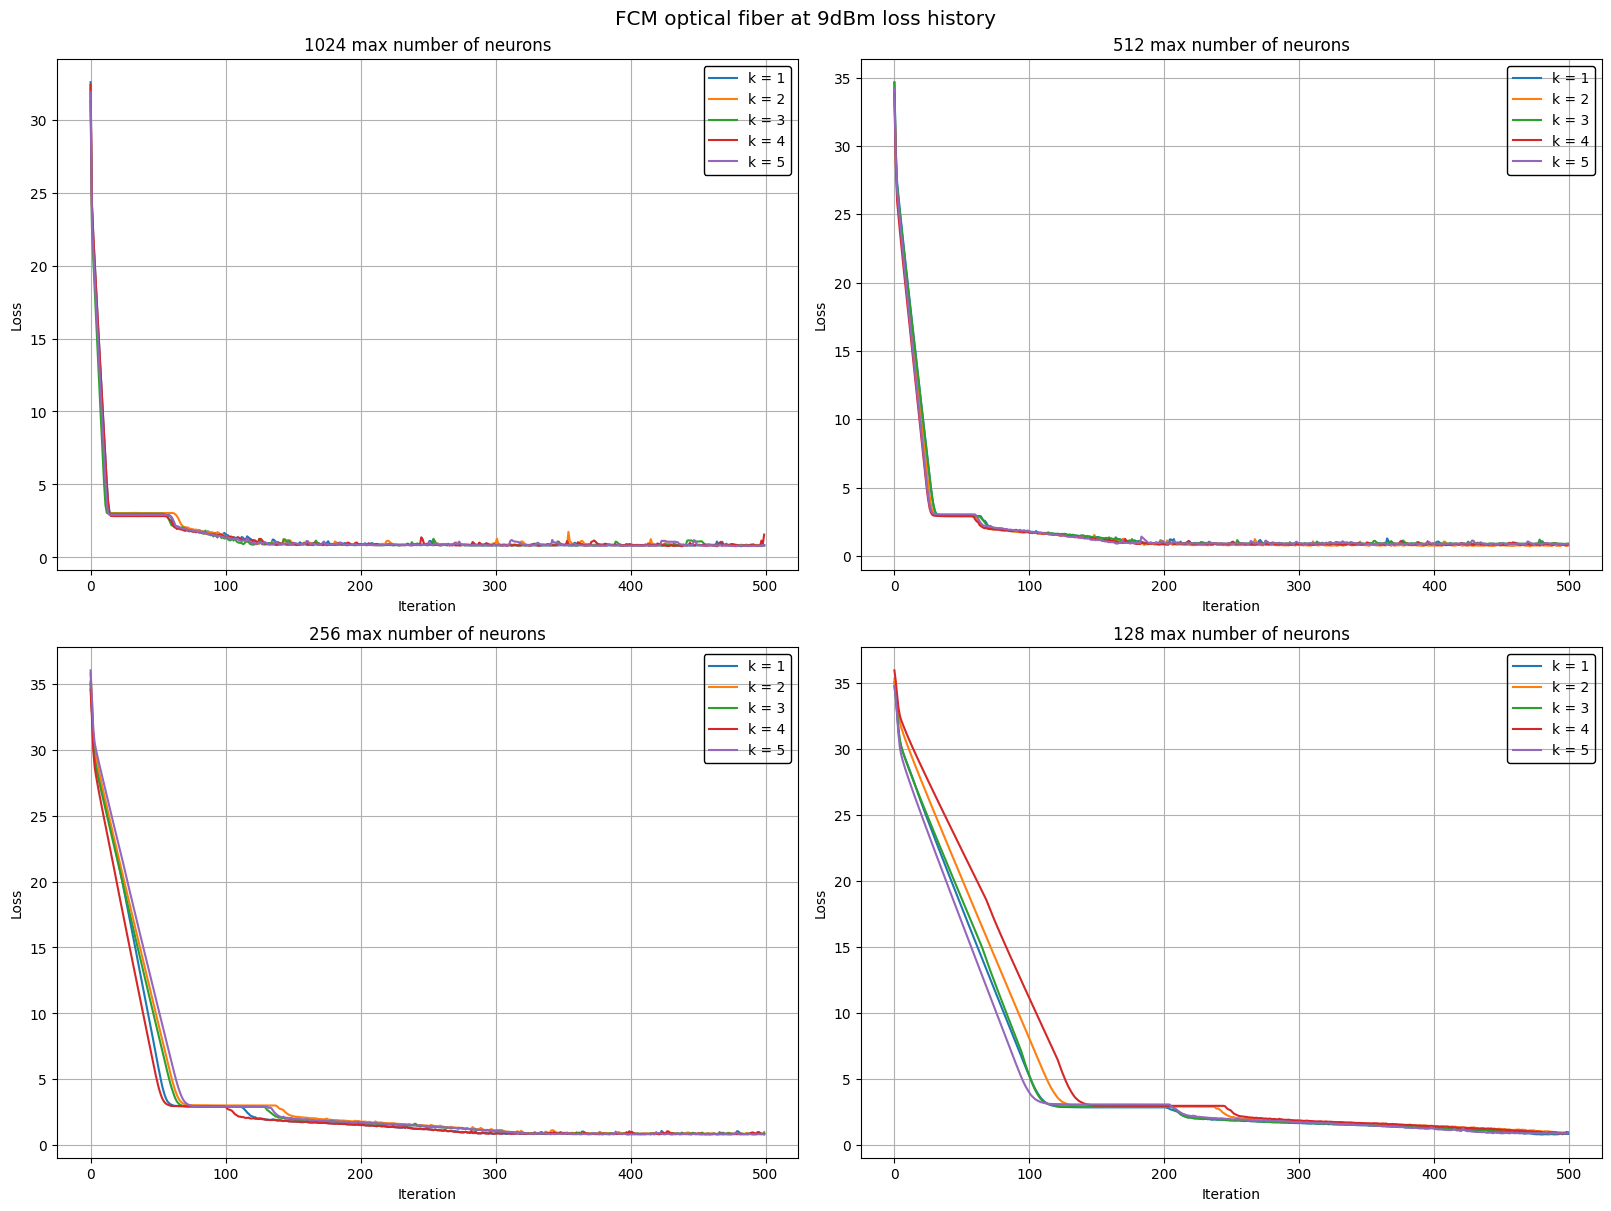

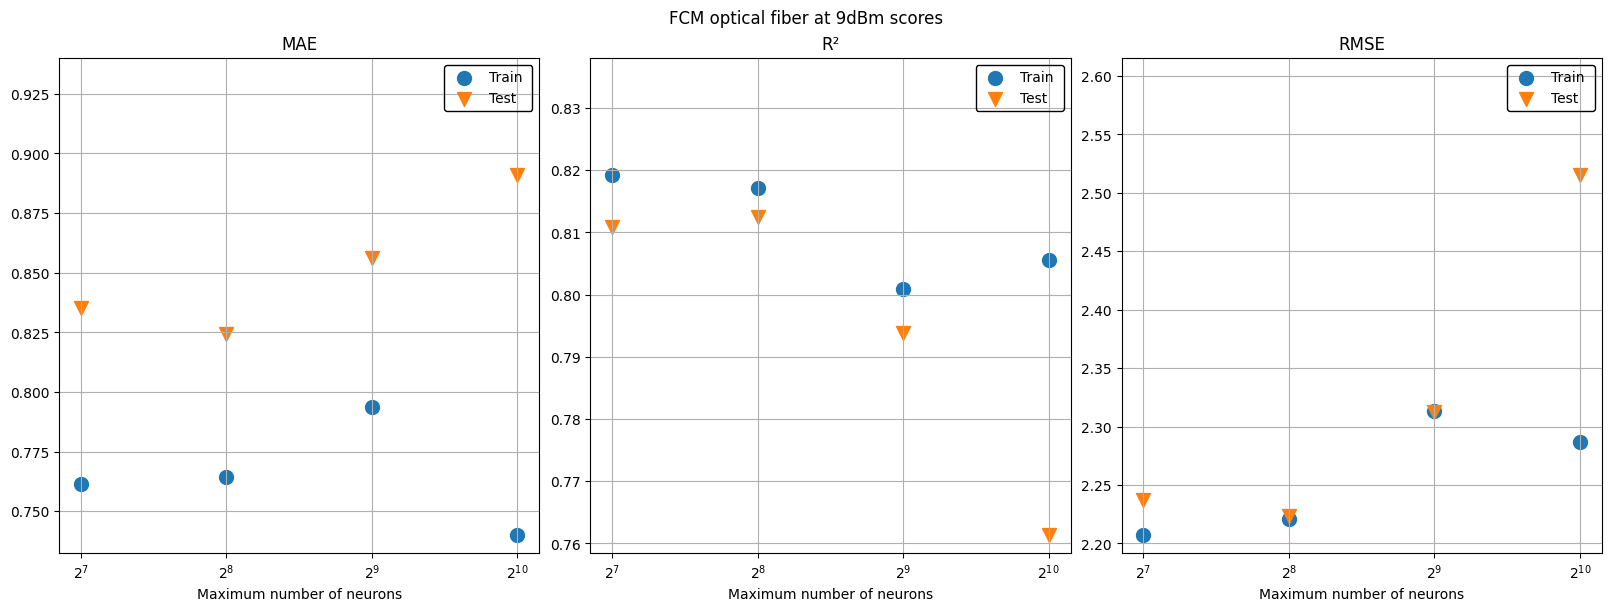

In [55]:
scores = [scores_FCM_1024_fiber9, scores_FCM_512_fiber9, scores_FCM_256_fiber9, scores_FCM_128_fiber9]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "FCM optical fiber at 9dBm")

### GKM B2B

In [56]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_B2B = calc_once("scores_GKM_1024_B2B", test_estimation_model, args)

In [57]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_B2B = calc_once("scores_GKM_512_B2B", test_estimation_model, args)

In [58]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_B2B = calc_once("scores_GKM_256_B2B", test_estimation_model, args)

In [59]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_B2B = calc_once("scores_GKM_128_B2B", test_estimation_model, args)

In [60]:
%store scores_GKM_1024_B2B
%store scores_GKM_512_B2B
%store scores_GKM_256_B2B
%store scores_GKM_128_B2B

Stored 'scores_GKM_1024_B2B' (dict)
Stored 'scores_GKM_512_B2B' (dict)
Stored 'scores_GKM_256_B2B' (dict)
Stored 'scores_GKM_128_B2B' (dict)


#### Gráficas

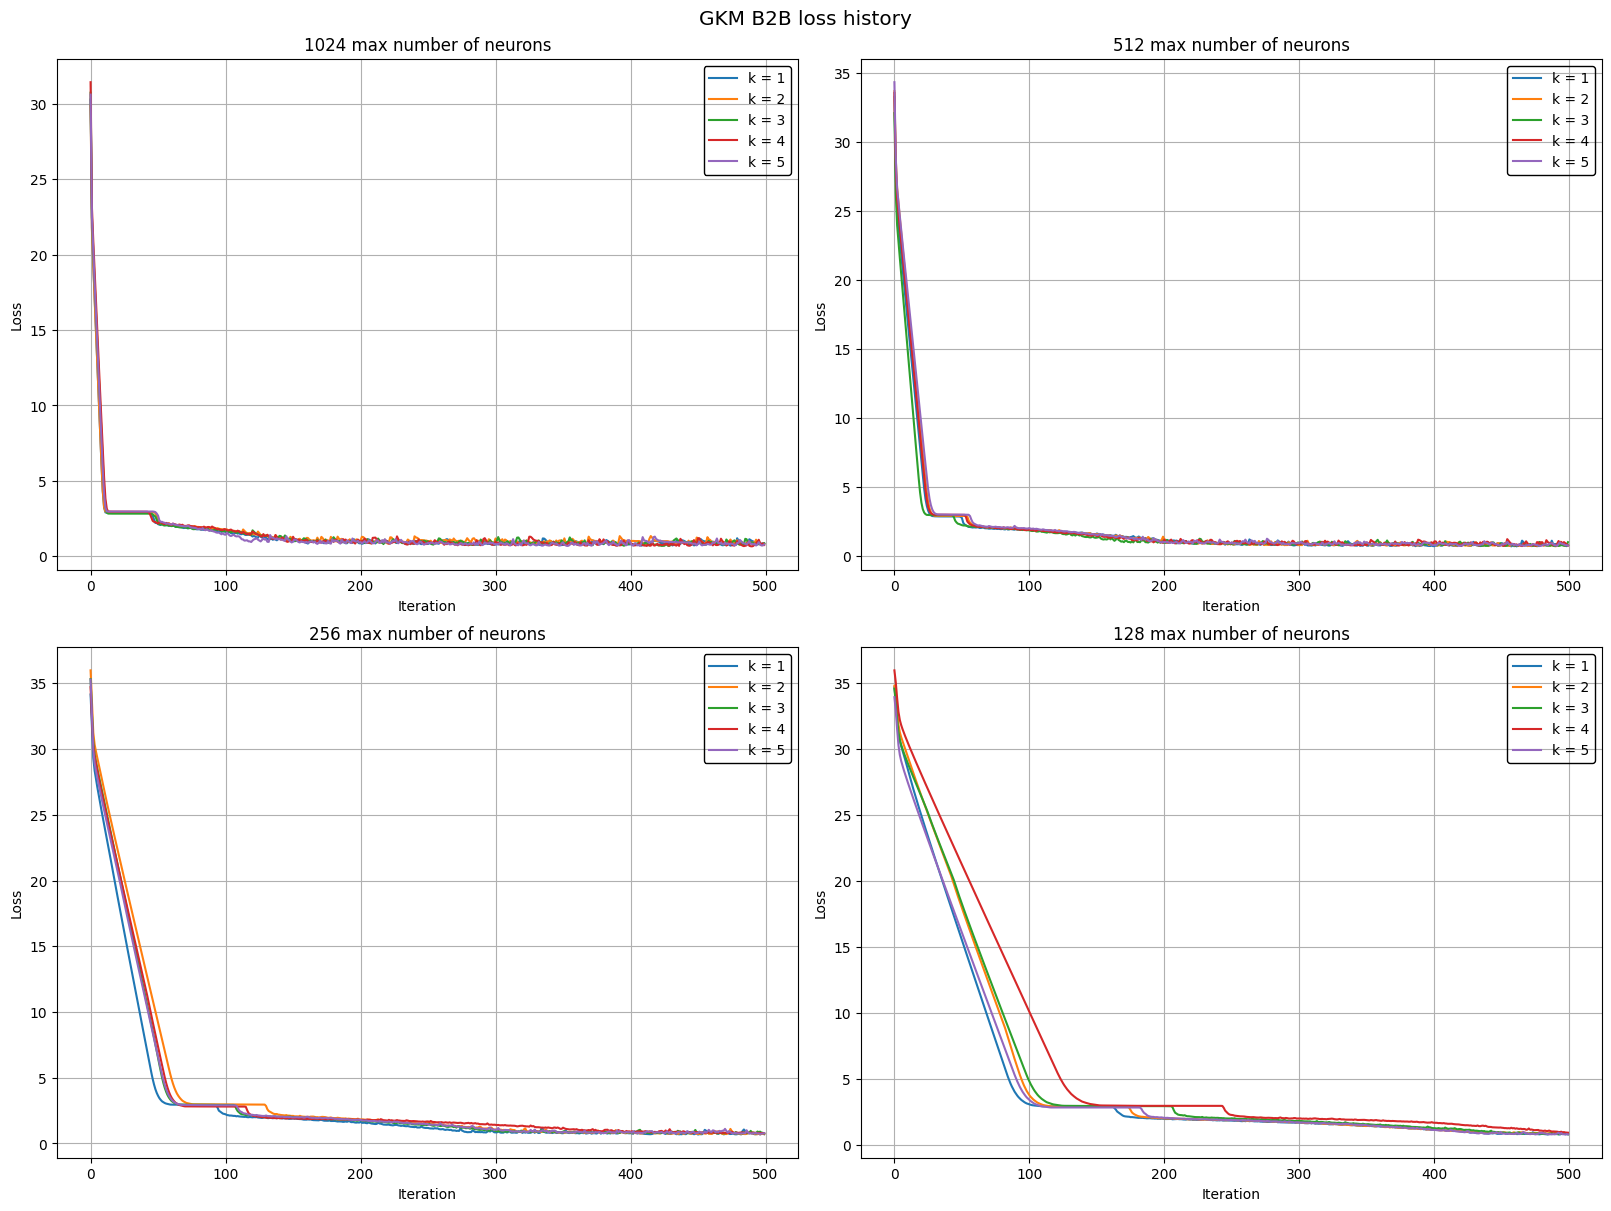

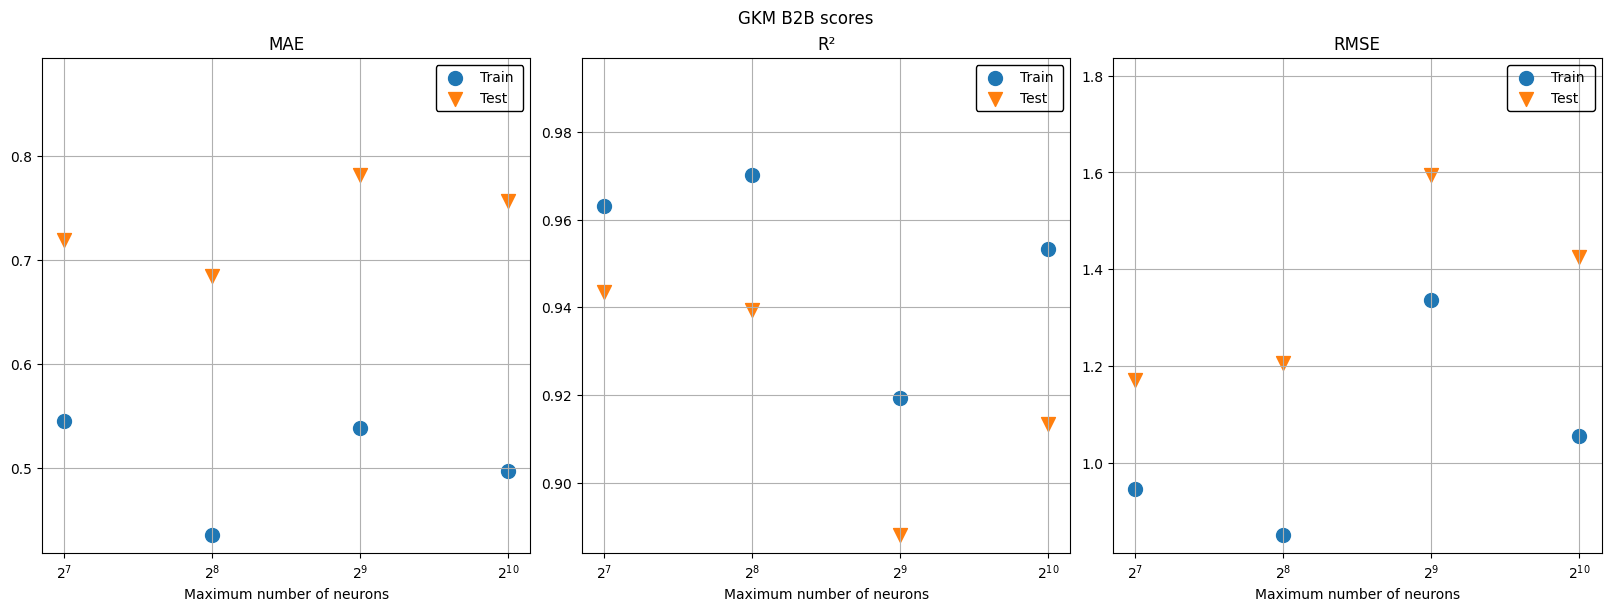

In [61]:
scores = [scores_GKM_1024_B2B, scores_GKM_512_B2B, scores_GKM_256_B2B, scores_GKM_128_B2B]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "GKM B2B")

### GKM con fibra óptica a 0dBm

In [62]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_fiber0 = calc_once("scores_GKM_1024_fiber0", test_estimation_model, args)

In [63]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_fiber0 = calc_once("scores_GKM_512_fiber0", test_estimation_model, args)

In [64]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_fiber0 = calc_once("scores_GKM_256_fiber0", test_estimation_model, args)

In [65]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_fiber0 = calc_once("scores_GKM_128_fiber0", test_estimation_model, args)

In [66]:
%store scores_GKM_1024_fiber0
%store scores_GKM_512_fiber0
%store scores_GKM_256_fiber0
%store scores_GKM_128_fiber0

Stored 'scores_GKM_1024_fiber0' (dict)
Stored 'scores_GKM_512_fiber0' (dict)
Stored 'scores_GKM_256_fiber0' (dict)
Stored 'scores_GKM_128_fiber0' (dict)


#### Gráficas

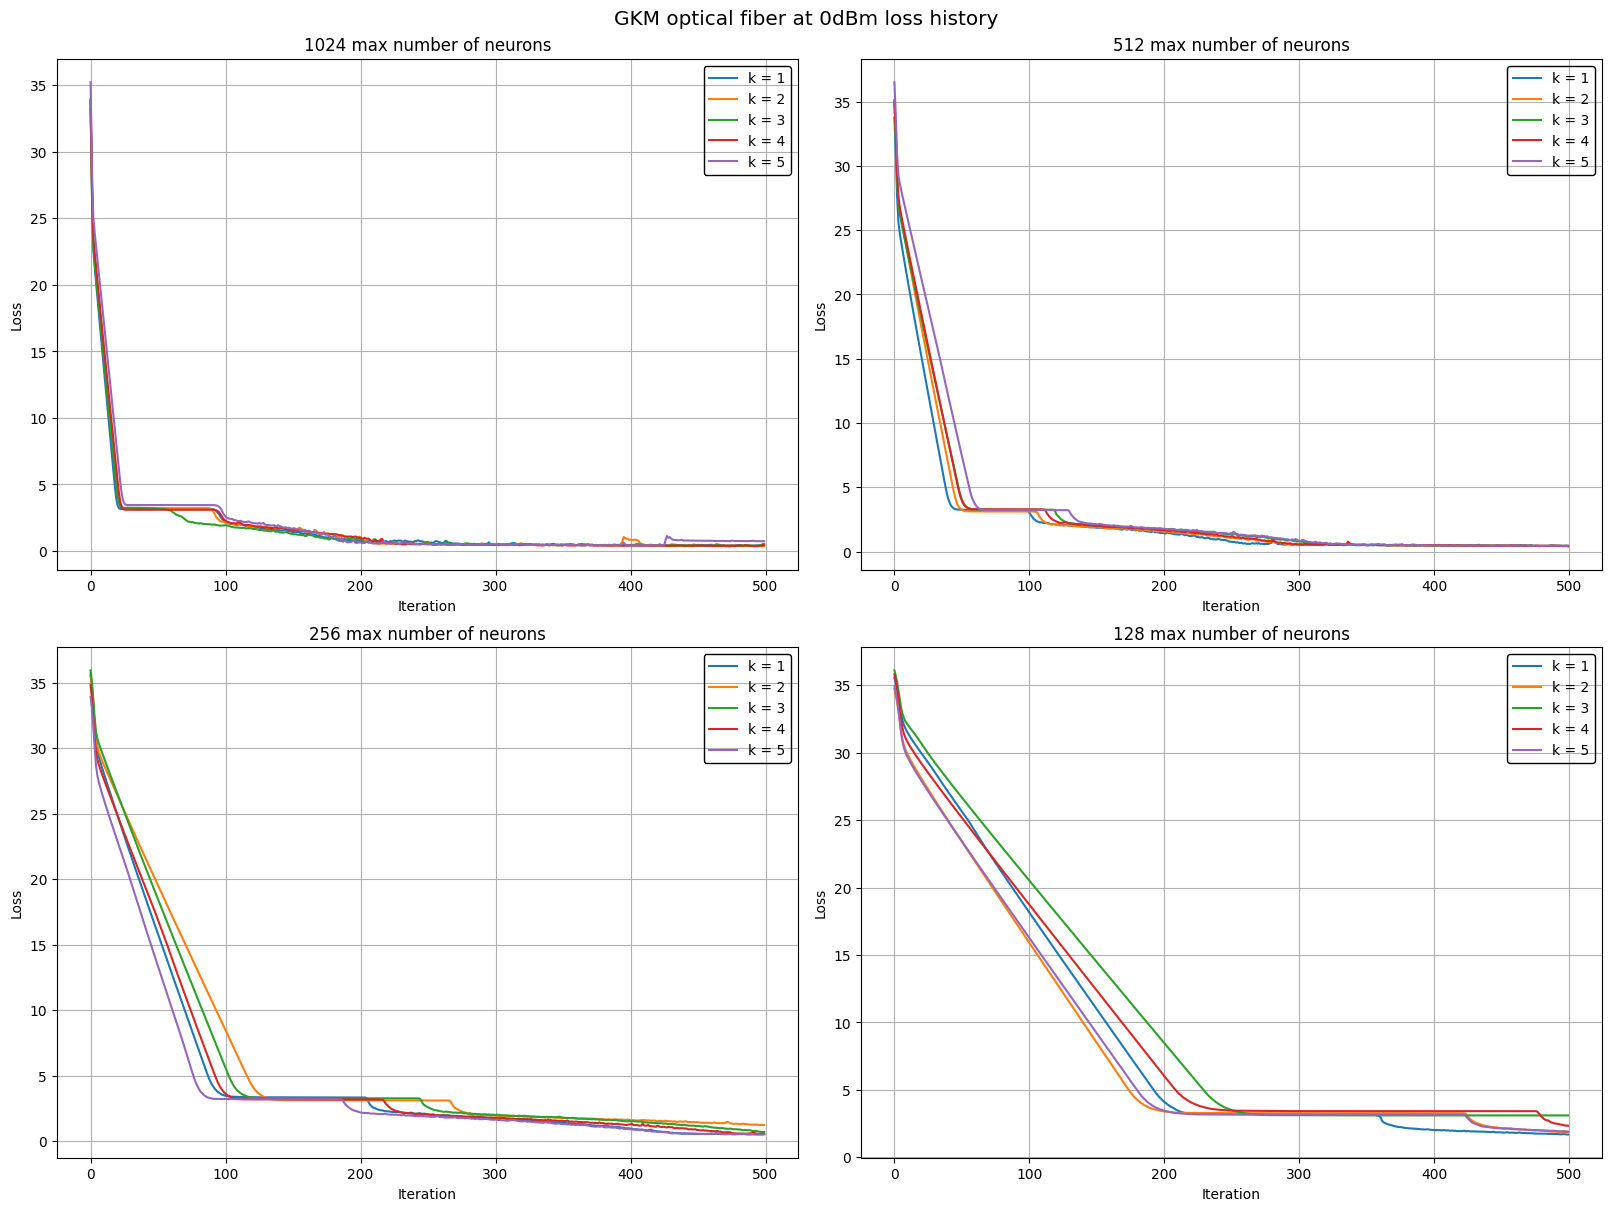

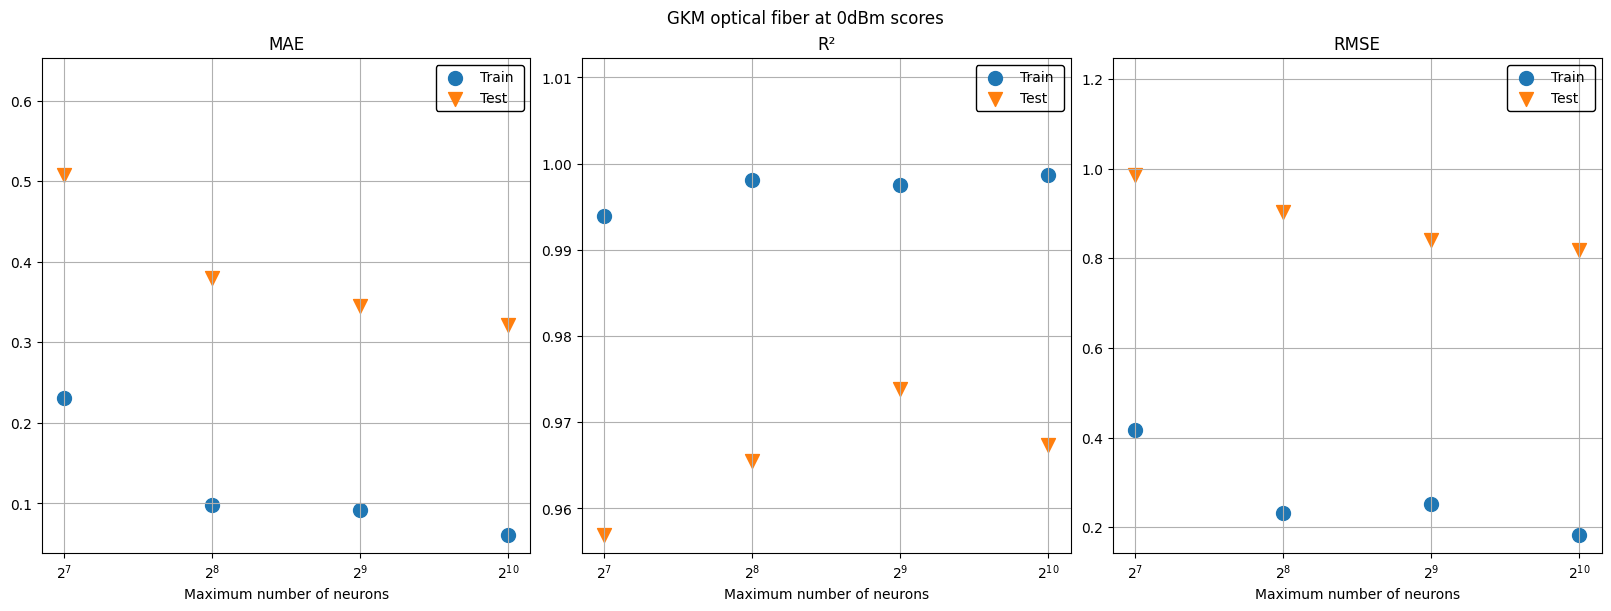

In [67]:
scores = [scores_GKM_1024_fiber0, scores_GKM_512_fiber0, scores_GKM_256_fiber0, scores_GKM_128_fiber0]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "GKM optical fiber at 0dBm")

### GKM con fibra óptica a 9dBm

In [68]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_fiber9 = calc_once("scores_GKM_1024_fiber9", test_estimation_model, args)

In [69]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_fiber9 = calc_once("scores_GKM_512_fiber9", test_estimation_model, args)

In [70]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_fiber9 = calc_once("scores_GKM_256_fiber9", test_estimation_model, args)

In [71]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_fiber9 = calc_once("scores_GKM_128_fiber9", test_estimation_model, args)

In [72]:
%store scores_GKM_1024_fiber9
%store scores_GKM_512_fiber9
%store scores_GKM_256_fiber9
%store scores_GKM_128_fiber9

Stored 'scores_GKM_1024_fiber9' (dict)
Stored 'scores_GKM_512_fiber9' (dict)
Stored 'scores_GKM_256_fiber9' (dict)
Stored 'scores_GKM_128_fiber9' (dict)


#### Gráficas

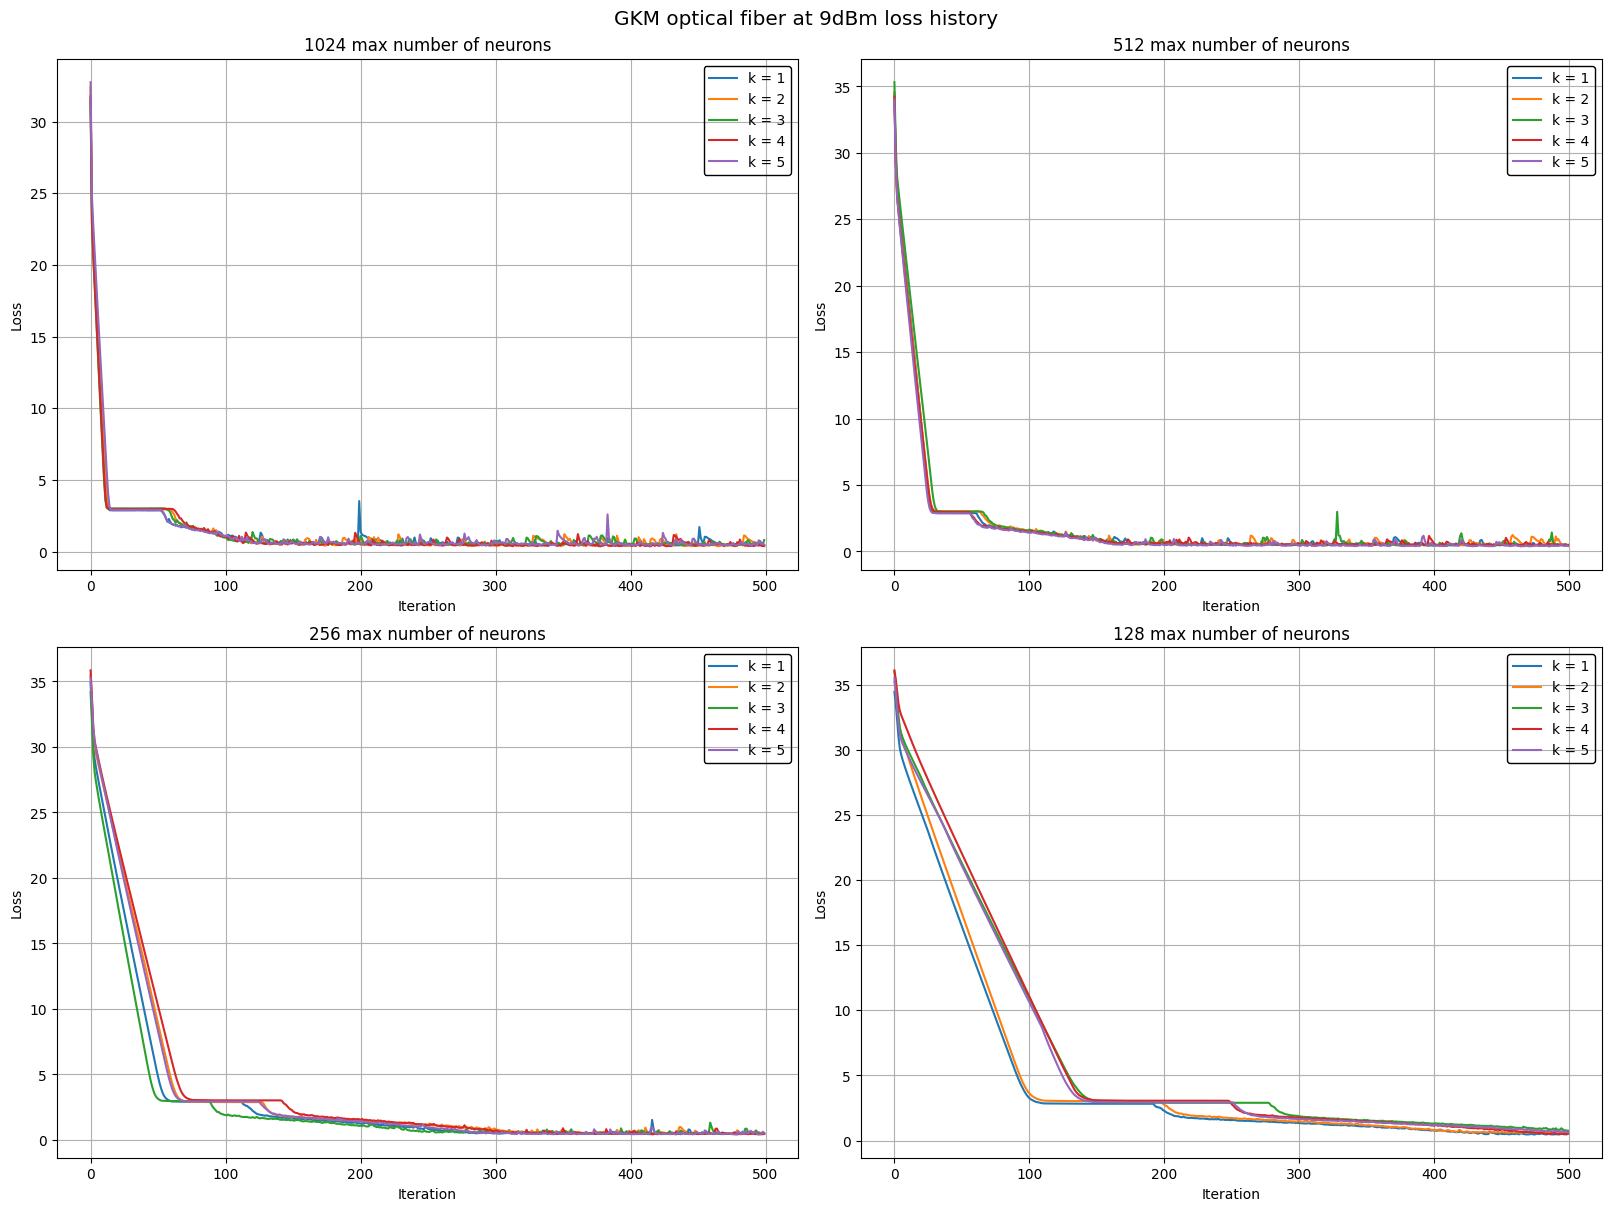

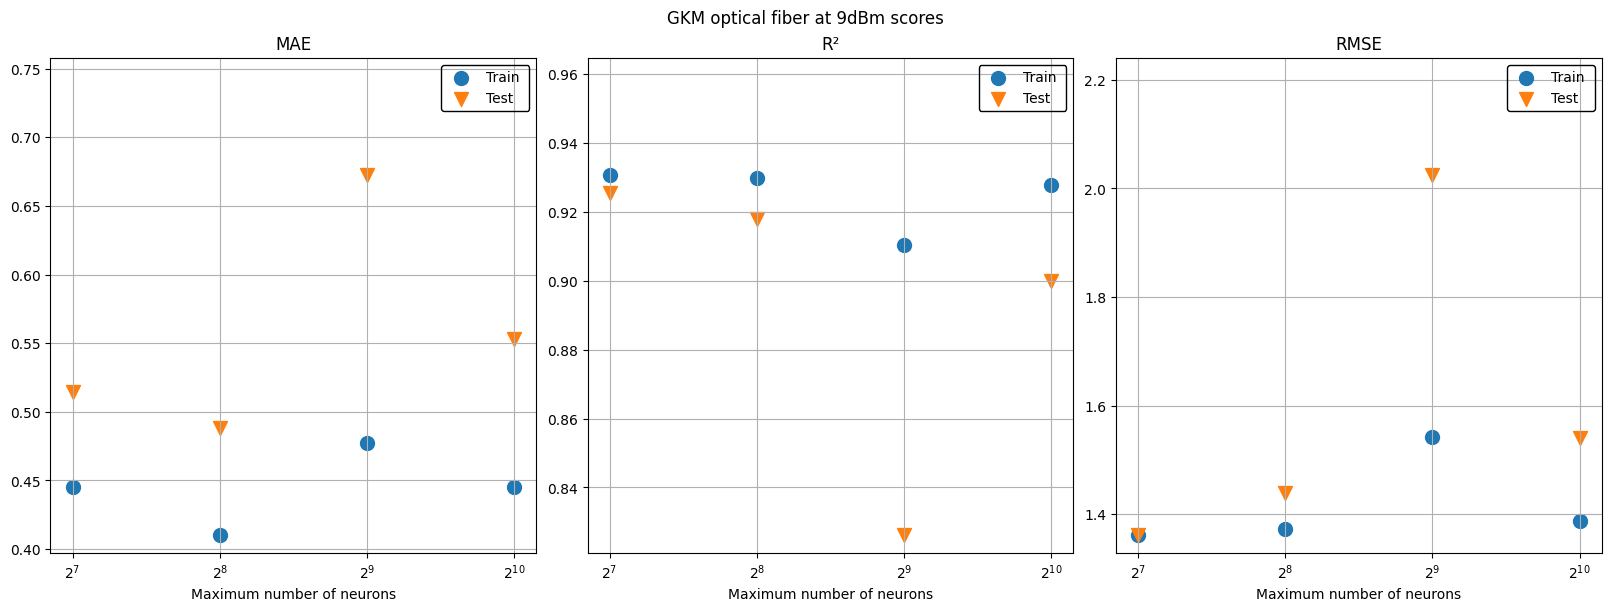

In [73]:
scores = [scores_GKM_1024_fiber9, scores_GKM_512_fiber9, scores_GKM_256_fiber9, scores_GKM_128_fiber9]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "GKM optical fiber at 9dBm")

## Comparación variando la primera función de activación (ReLu vs. Swish)

### B2B

In [74]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_B2B = calc_once("scores_FCM_relu_B2B", test_estimation_model, args)

In [75]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_B2B = calc_once("scores_GKM_relu_B2B", test_estimation_model, args)

In [76]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_B2B = calc_once("scores_FCM_swish_B2B", test_estimation_model, args)

In [77]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_B2B = calc_once("scores_GKM_swish_B2B", test_estimation_model, args)

In [78]:
%store scores_FCM_relu_B2B
%store scores_GKM_relu_B2B
%store scores_FCM_swish_B2B
%store scores_GKM_swish_B2B

Stored 'scores_FCM_relu_B2B' (dict)
Stored 'scores_GKM_relu_B2B' (dict)
Stored 'scores_FCM_swish_B2B' (dict)
Stored 'scores_GKM_swish_B2B' (dict)


In [79]:
#scores = [scores_FCM_relu_B2B, scores_GKM_relu_B2B, scores_FCM_swish_B2B, scores_GKM_swish_B2B]
#plot_activations_scores(scores, "ReLu vs. Swish, B2B")

### Fibra óptica a 0dBm

In [80]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_fiber0 = calc_once("scores_FCM_relu_fiber0", test_estimation_model, args)

In [81]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_fiber0 = calc_once("scores_GKM_relu_fiber0", test_estimation_model, args)

In [82]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_fiber0 = calc_once("scores_FCM_swish_fiber0", test_estimation_model, args)

In [83]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_fiber0 = calc_once("scores_GKM_swish_fiber0", test_estimation_model, args)

In [84]:
%store scores_FCM_relu_fiber0
%store scores_GKM_relu_fiber0
%store scores_FCM_swish_fiber0
%store scores_GKM_swish_fiber0

Stored 'scores_FCM_relu_fiber0' (dict)
Stored 'scores_GKM_relu_fiber0' (dict)
Stored 'scores_FCM_swish_fiber0' (dict)
Stored 'scores_GKM_swish_fiber0' (dict)


In [85]:
#scores = [scores_FCM_relu_fiber0, scores_GKM_relu_fiber0, scores_FCM_swish_fiber0, scores_GKM_swish_fiber0]
#plot_activations_scores(scores, "ReLu vs. Swish, optical fiber at 0dBm")

### Fibra óptica a 9dBm

In [86]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_fiber9 = calc_once("scores_FCM_relu_fiber9", test_estimation_model, args)

In [87]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_fiber9 = calc_once("scores_GKM_relu_fiber9", test_estimation_model, args)

In [88]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_fiber9 = calc_once("scores_FCM_swish_fiber9", test_estimation_model, args)

In [89]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_fiber9 = calc_once("scores_GKM_swish_fiber9", test_estimation_model, args)

In [90]:
%store scores_FCM_relu_fiber9
%store scores_GKM_relu_fiber9
%store scores_FCM_swish_fiber9
%store scores_GKM_swish_fiber9

Stored 'scores_FCM_relu_fiber9' (dict)
Stored 'scores_GKM_relu_fiber9' (dict)
Stored 'scores_FCM_swish_fiber9' (dict)
Stored 'scores_GKM_swish_fiber9' (dict)


In [91]:
#scores = [scores_FCM_relu_fiber9, scores_GKM_relu_fiber9, scores_FCM_swish_fiber9, scores_GKM_swish_fiber9]
#plot_activations_scores(scores, "ReLu vs. Swish, optical fiber at 9dBm")

## Comparación variando el número de capas ocultas

### B2B

In [92]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_FCM_B2B_1HL = calc_once("scores_FCM_B2B_1HL", test_estimation_model, args)

In [93]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_FCM_B2B_2HL = calc_once("scores_FCM_B2B_2HL", test_estimation_model, args)

In [94]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_B2B_3HL = calc_once("scores_FCM_B2B_3HL", test_estimation_model, args)

In [95]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_FCM_B2B_4HL = calc_once("scores_FCM_B2B_4HL", test_estimation_model, args)

In [96]:
%store scores_FCM_B2B_1HL
%store scores_FCM_B2B_2HL
%store scores_FCM_B2B_3HL
%store scores_FCM_B2B_4HL

Stored 'scores_FCM_B2B_1HL' (dict)
Stored 'scores_FCM_B2B_2HL' (dict)
Stored 'scores_FCM_B2B_3HL' (dict)
Stored 'scores_FCM_B2B_4HL' (dict)


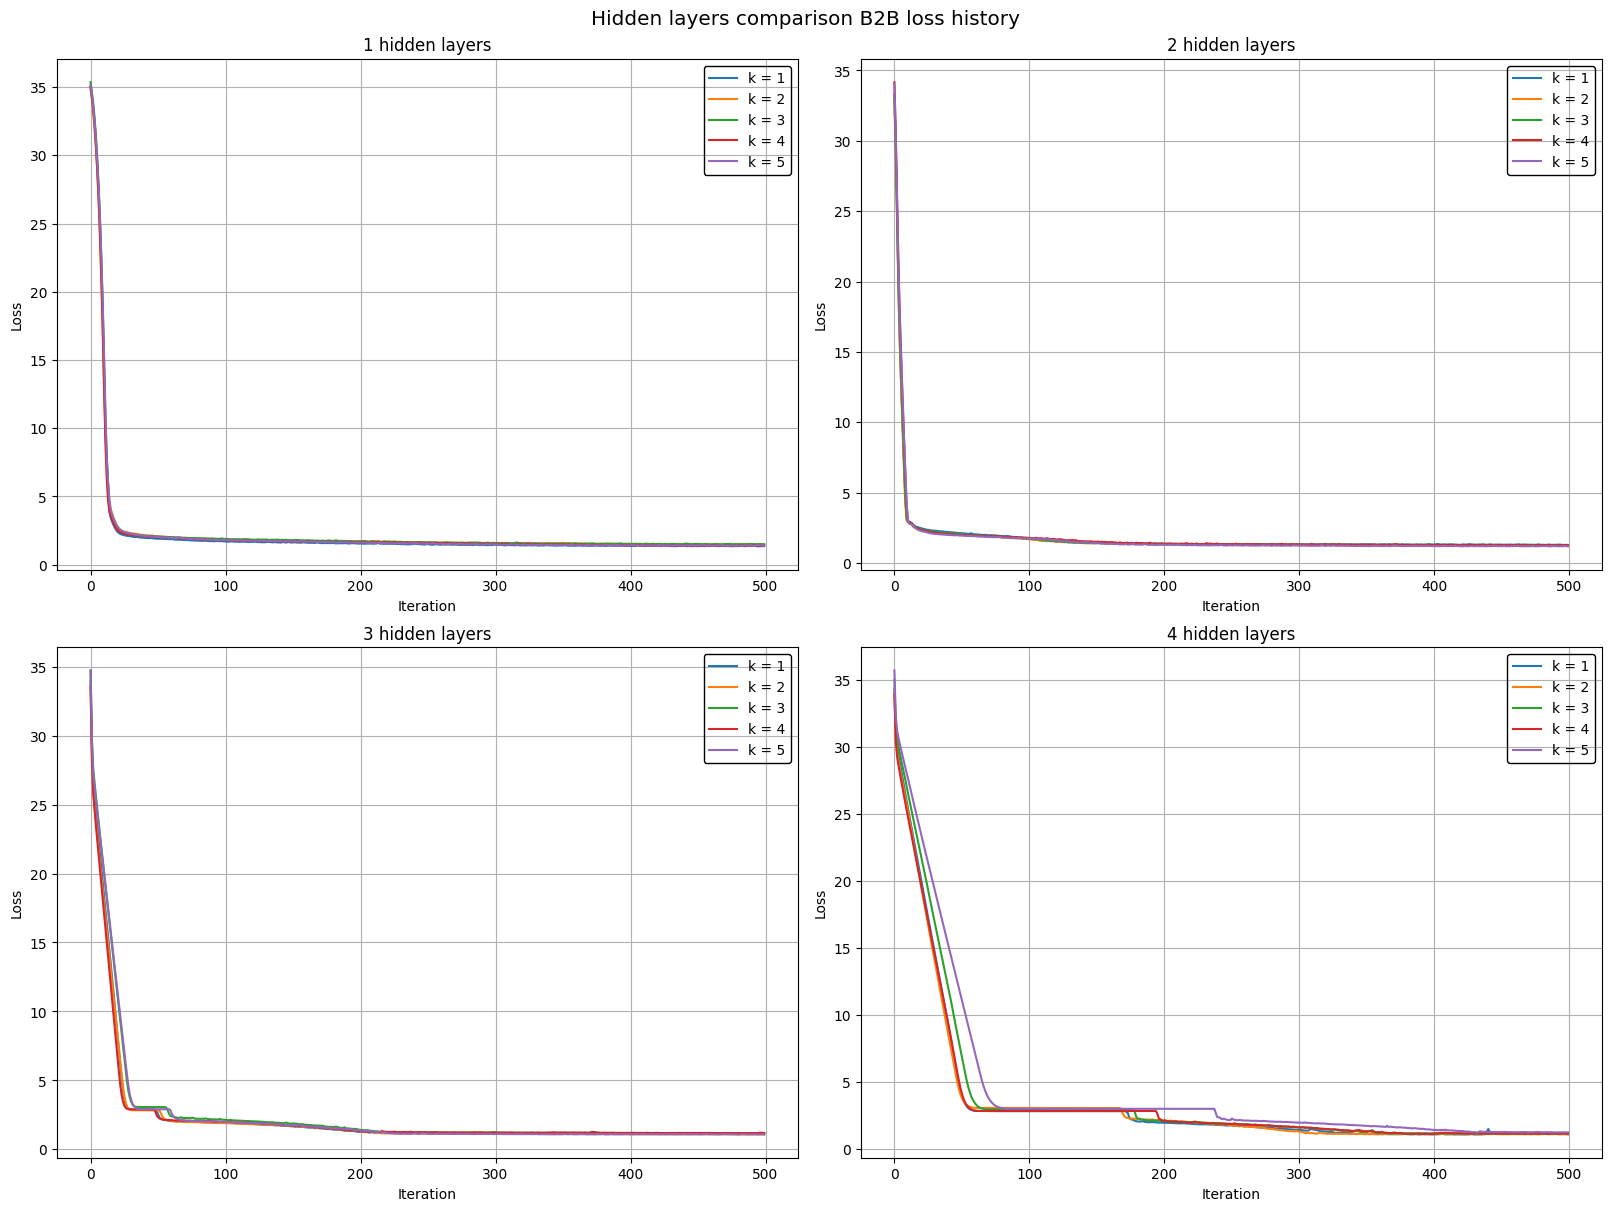

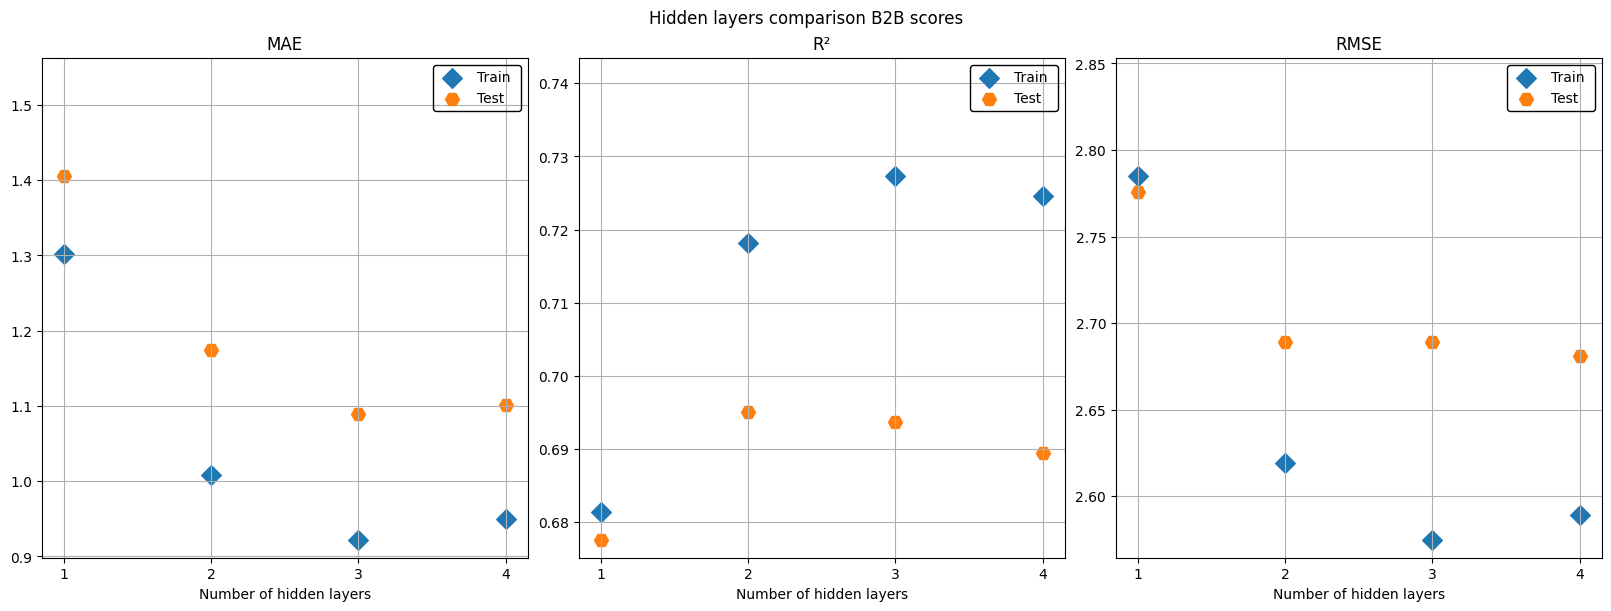

In [97]:
scores = [scores_FCM_B2B_1HL, scores_FCM_B2B_2HL, scores_FCM_B2B_3HL, scores_FCM_B2B_4HL]
plot_layers_scores(scores, "Hidden layers comparison B2B")

### Fibra óptica a 0dBm

In [98]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_FCM_fiber0_1HL = calc_once("scores_FCM_fiber0_1HL", test_estimation_model, args)

In [99]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_FCM_fiber0_2HL = calc_once("scores_FCM_fiber0_2HL", test_estimation_model, args)

In [100]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_fiber0_3HL = calc_once("scores_FCM_fiber0_3HL", test_estimation_model, args)

In [101]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_FCM_fiber0_4HL = calc_once("scores_FCM_fiber0_4HL", test_estimation_model, args)

In [102]:
%store scores_FCM_fiber0_1HL
%store scores_FCM_fiber0_2HL
%store scores_FCM_fiber0_3HL
%store scores_FCM_fiber0_4HL

Stored 'scores_FCM_fiber0_1HL' (dict)
Stored 'scores_FCM_fiber0_2HL' (dict)
Stored 'scores_FCM_fiber0_3HL' (dict)
Stored 'scores_FCM_fiber0_4HL' (dict)


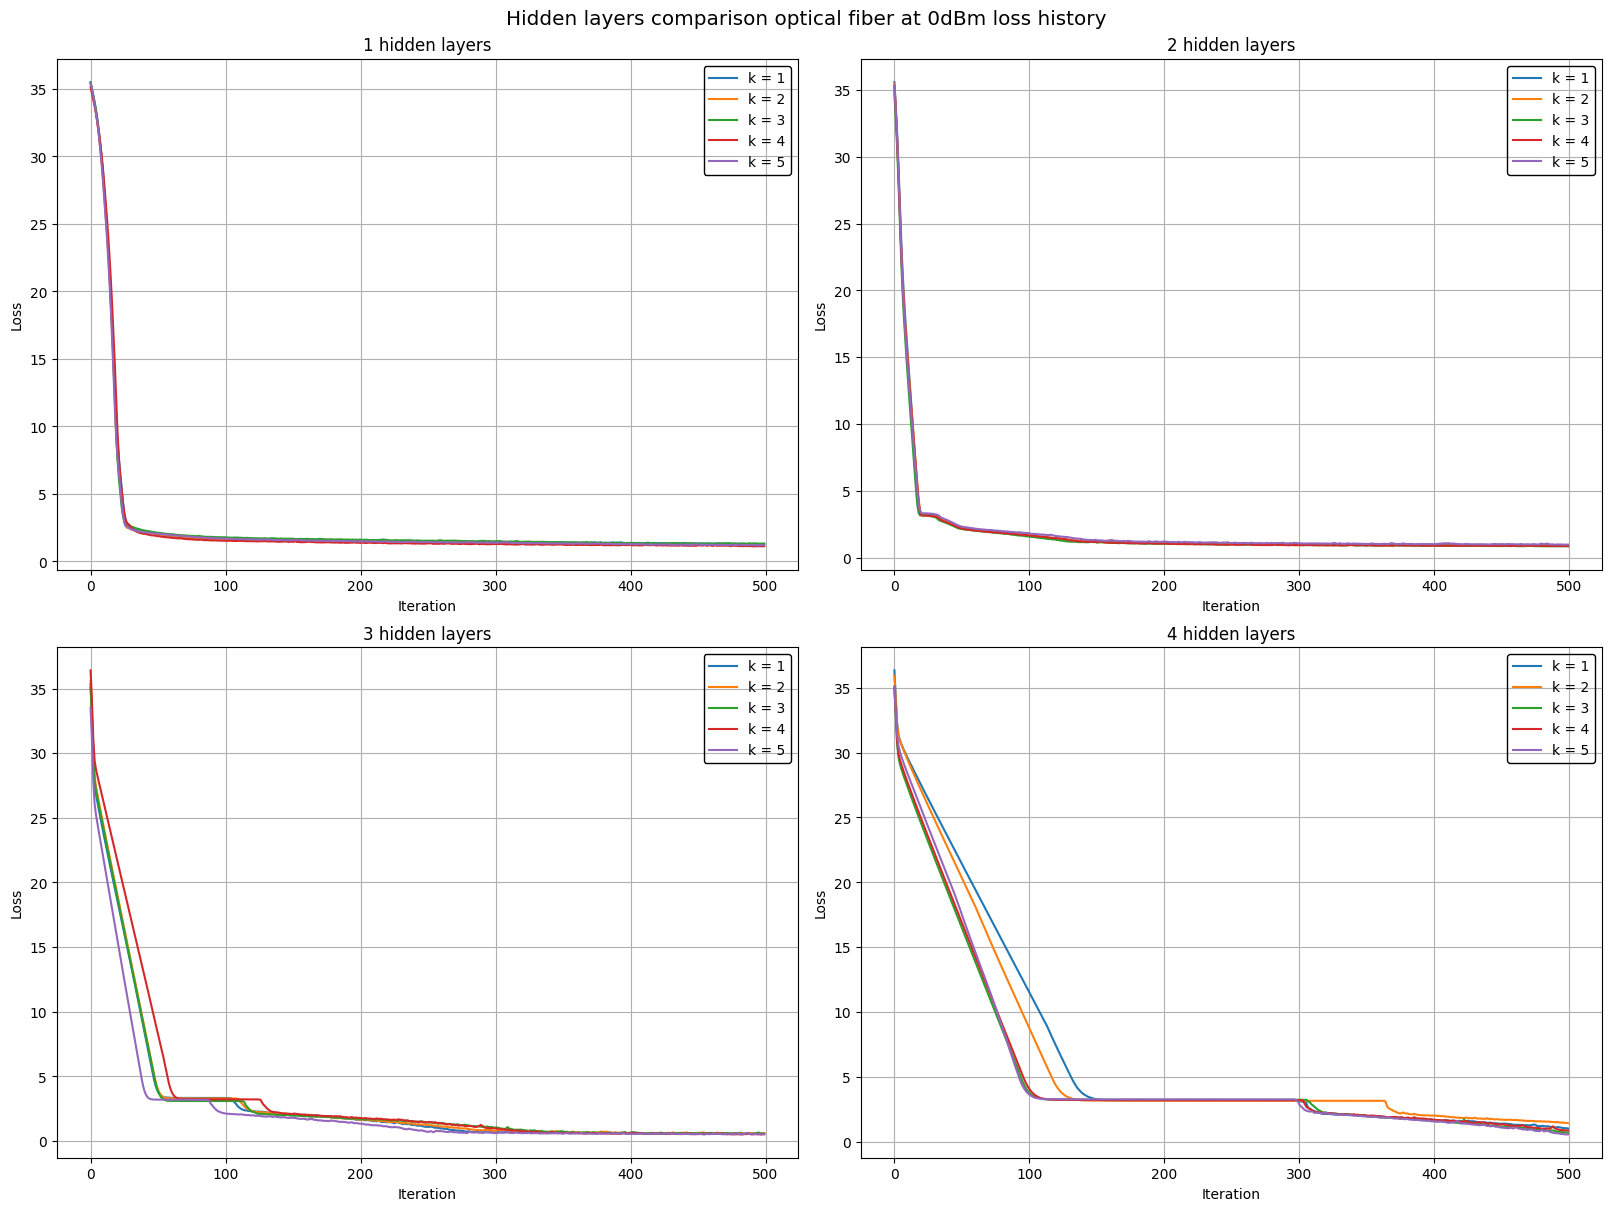

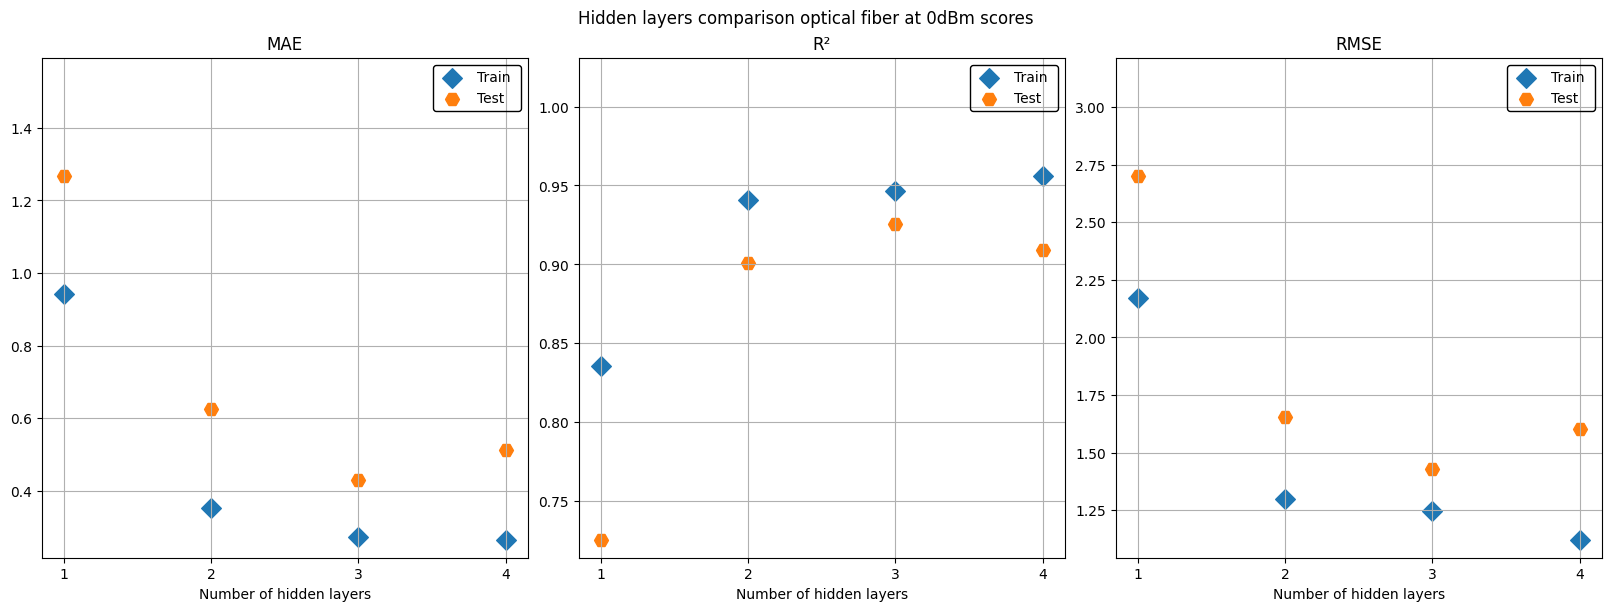

In [103]:
scores = [scores_FCM_fiber0_1HL, scores_FCM_fiber0_2HL, scores_FCM_fiber0_3HL, scores_FCM_fiber0_4HL]
plot_layers_scores(scores, "Hidden layers comparison optical fiber at 0dBm")

### Fibra óptica a 9dBm

In [104]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_FCM_fiber9_1HL = calc_once("scores_FCM_fiber9_1HL", test_estimation_model, args)

In [105]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_FCM_fiber9_2HL = calc_once("scores_FCM_fiber9_2HL", test_estimation_model, args)

In [106]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_fiber9_3HL = calc_once("scores_FCM_fiber9_3HL", test_estimation_model, args)

In [107]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_FCM_fiber9_4HL = calc_once("scores_FCM_fiber9_4HL", test_estimation_model, args)

In [108]:
%store scores_FCM_fiber9_1HL
%store scores_FCM_fiber9_2HL
%store scores_FCM_fiber9_3HL
%store scores_FCM_fiber9_4HL

Stored 'scores_FCM_fiber9_1HL' (dict)
Stored 'scores_FCM_fiber9_2HL' (dict)
Stored 'scores_FCM_fiber9_3HL' (dict)
Stored 'scores_FCM_fiber9_4HL' (dict)


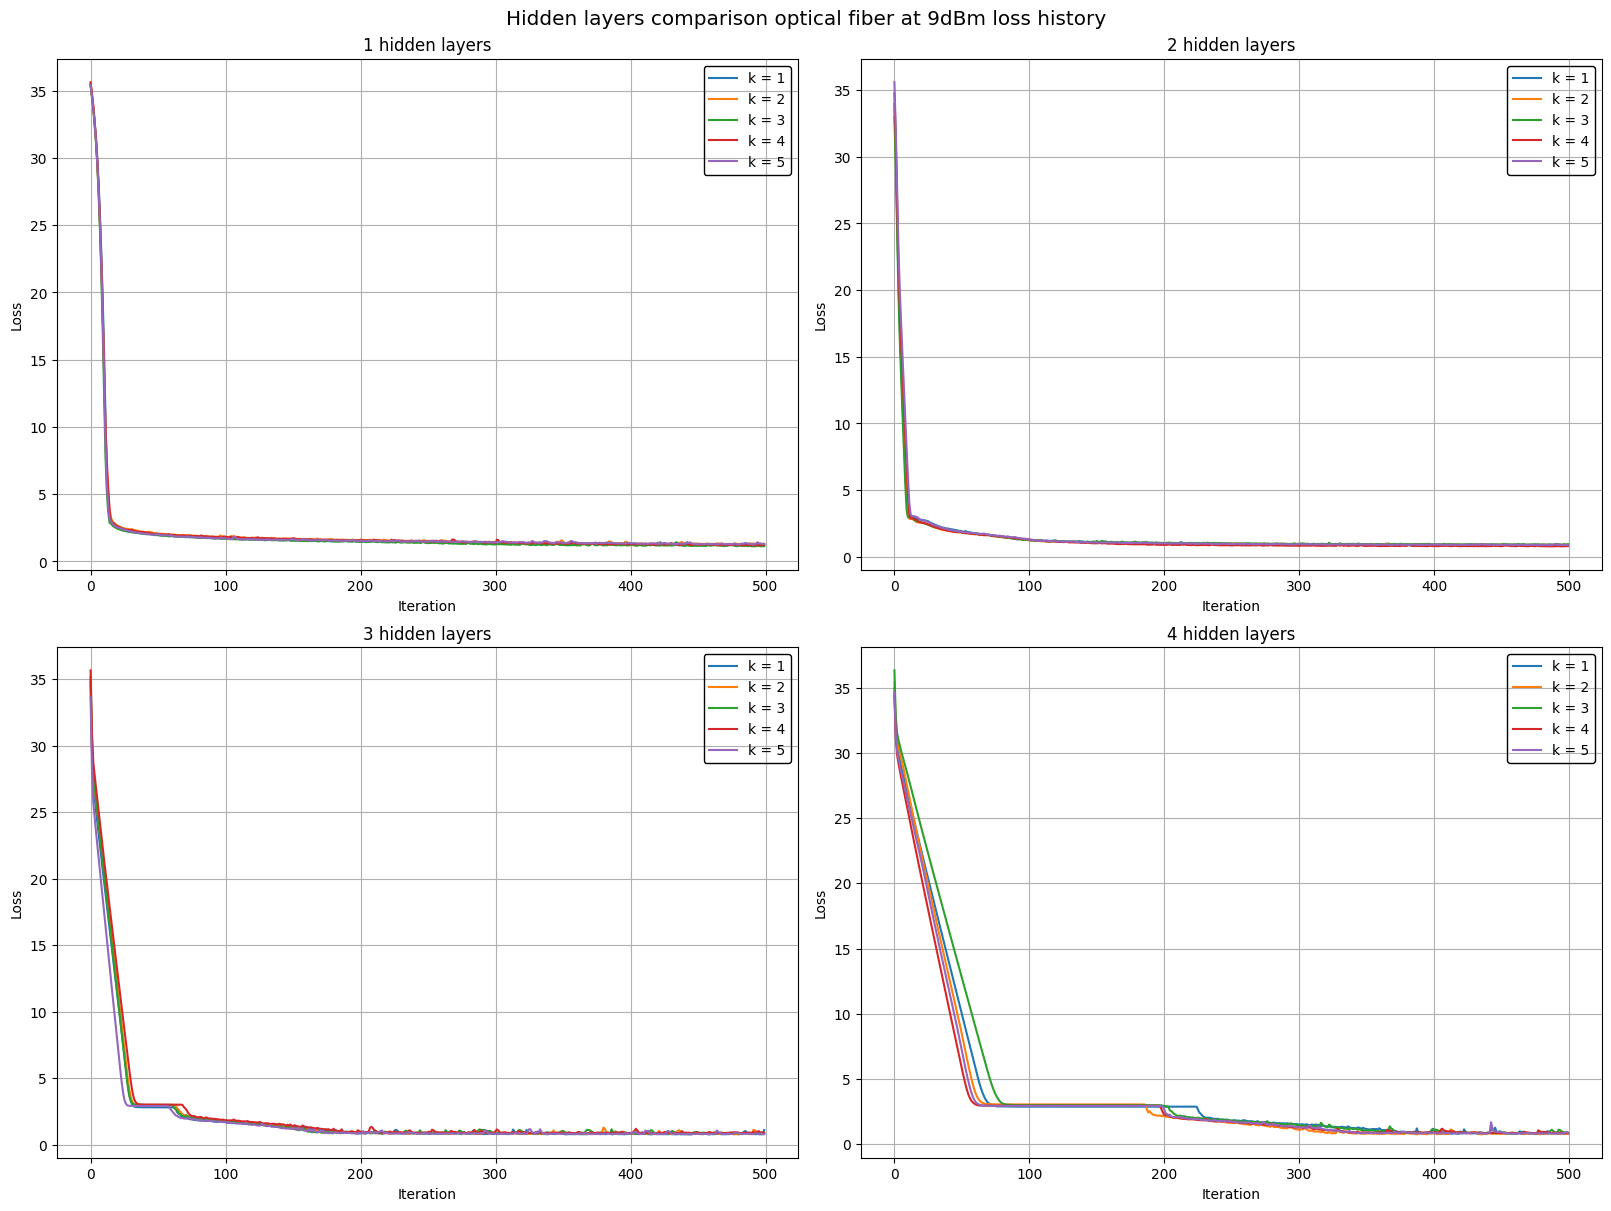

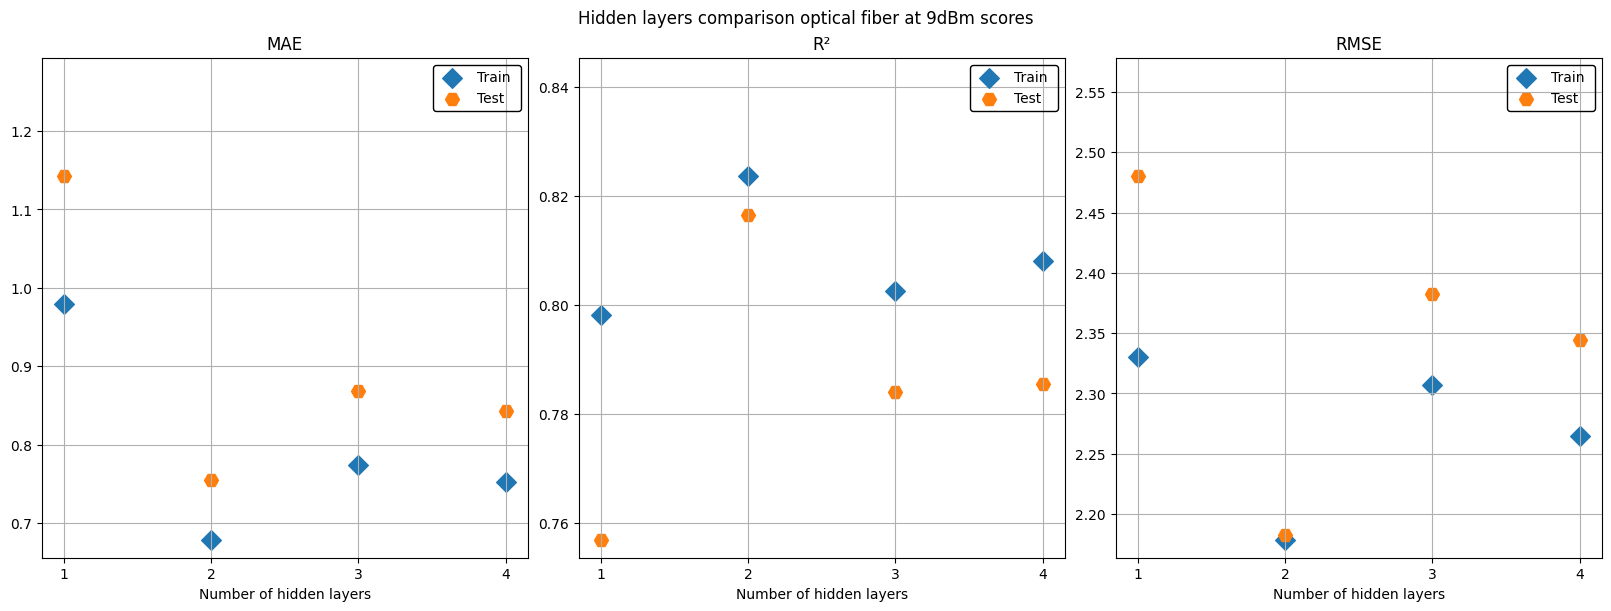

In [109]:
scores = [scores_FCM_fiber9_1HL, scores_FCM_fiber9_2HL, scores_FCM_fiber9_3HL, scores_FCM_fiber9_4HL]
plot_layers_scores(scores, "Hidden layers comparison optical fiber at 9dBm")

## Comparación variando la función de pérdida (MAE vs. RMSE)

In [119]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_absolute_error"}
scores_FCM_MAE_B2B = calc_once("scores_FCM_MAE_B2B", test_estimation_model, args)

In [120]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_squared_error"}
scores_FCM_MSE_B2B = calc_once("scores_FCM_MSE_B2B", test_estimation_model, args)

In [121]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_absolute_error"}
scores_FCM_MAE_fiber0 = calc_once("scores_FCM_MAE_fiber0", test_estimation_model, args)

In [122]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_squared_error"}
scores_FCM_MSE_fiber0 = calc_once("scores_FCM_MSE_fiber0", test_estimation_model, args)

In [123]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_absolute_error"}
scores_FCM_MAE_fiber9 = calc_once("scores_FCM_MAE_fiber9", test_estimation_model, args)

In [124]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_squared_error"}
scores_FCM_MSE_fiber9 = calc_once("scores_FCM_MSE_fiber9", test_estimation_model, args)

In [125]:
%store scores_FCM_MAE_B2B
%store scores_FCM_MSE_B2B
%store scores_FCM_MAE_fiber0
%store scores_FCM_MSE_fiber0
%store scores_FCM_MAE_fiber9
%store scores_FCM_MSE_fiber9

Stored 'scores_FCM_MAE_B2B' (dict)
Stored 'scores_FCM_MSE_B2B' (dict)
Stored 'scores_FCM_MAE_fiber0' (dict)
Stored 'scores_FCM_MSE_fiber0' (dict)
Stored 'scores_FCM_MAE_fiber9' (dict)
Stored 'scores_FCM_MSE_fiber9' (dict)


### Gráficas

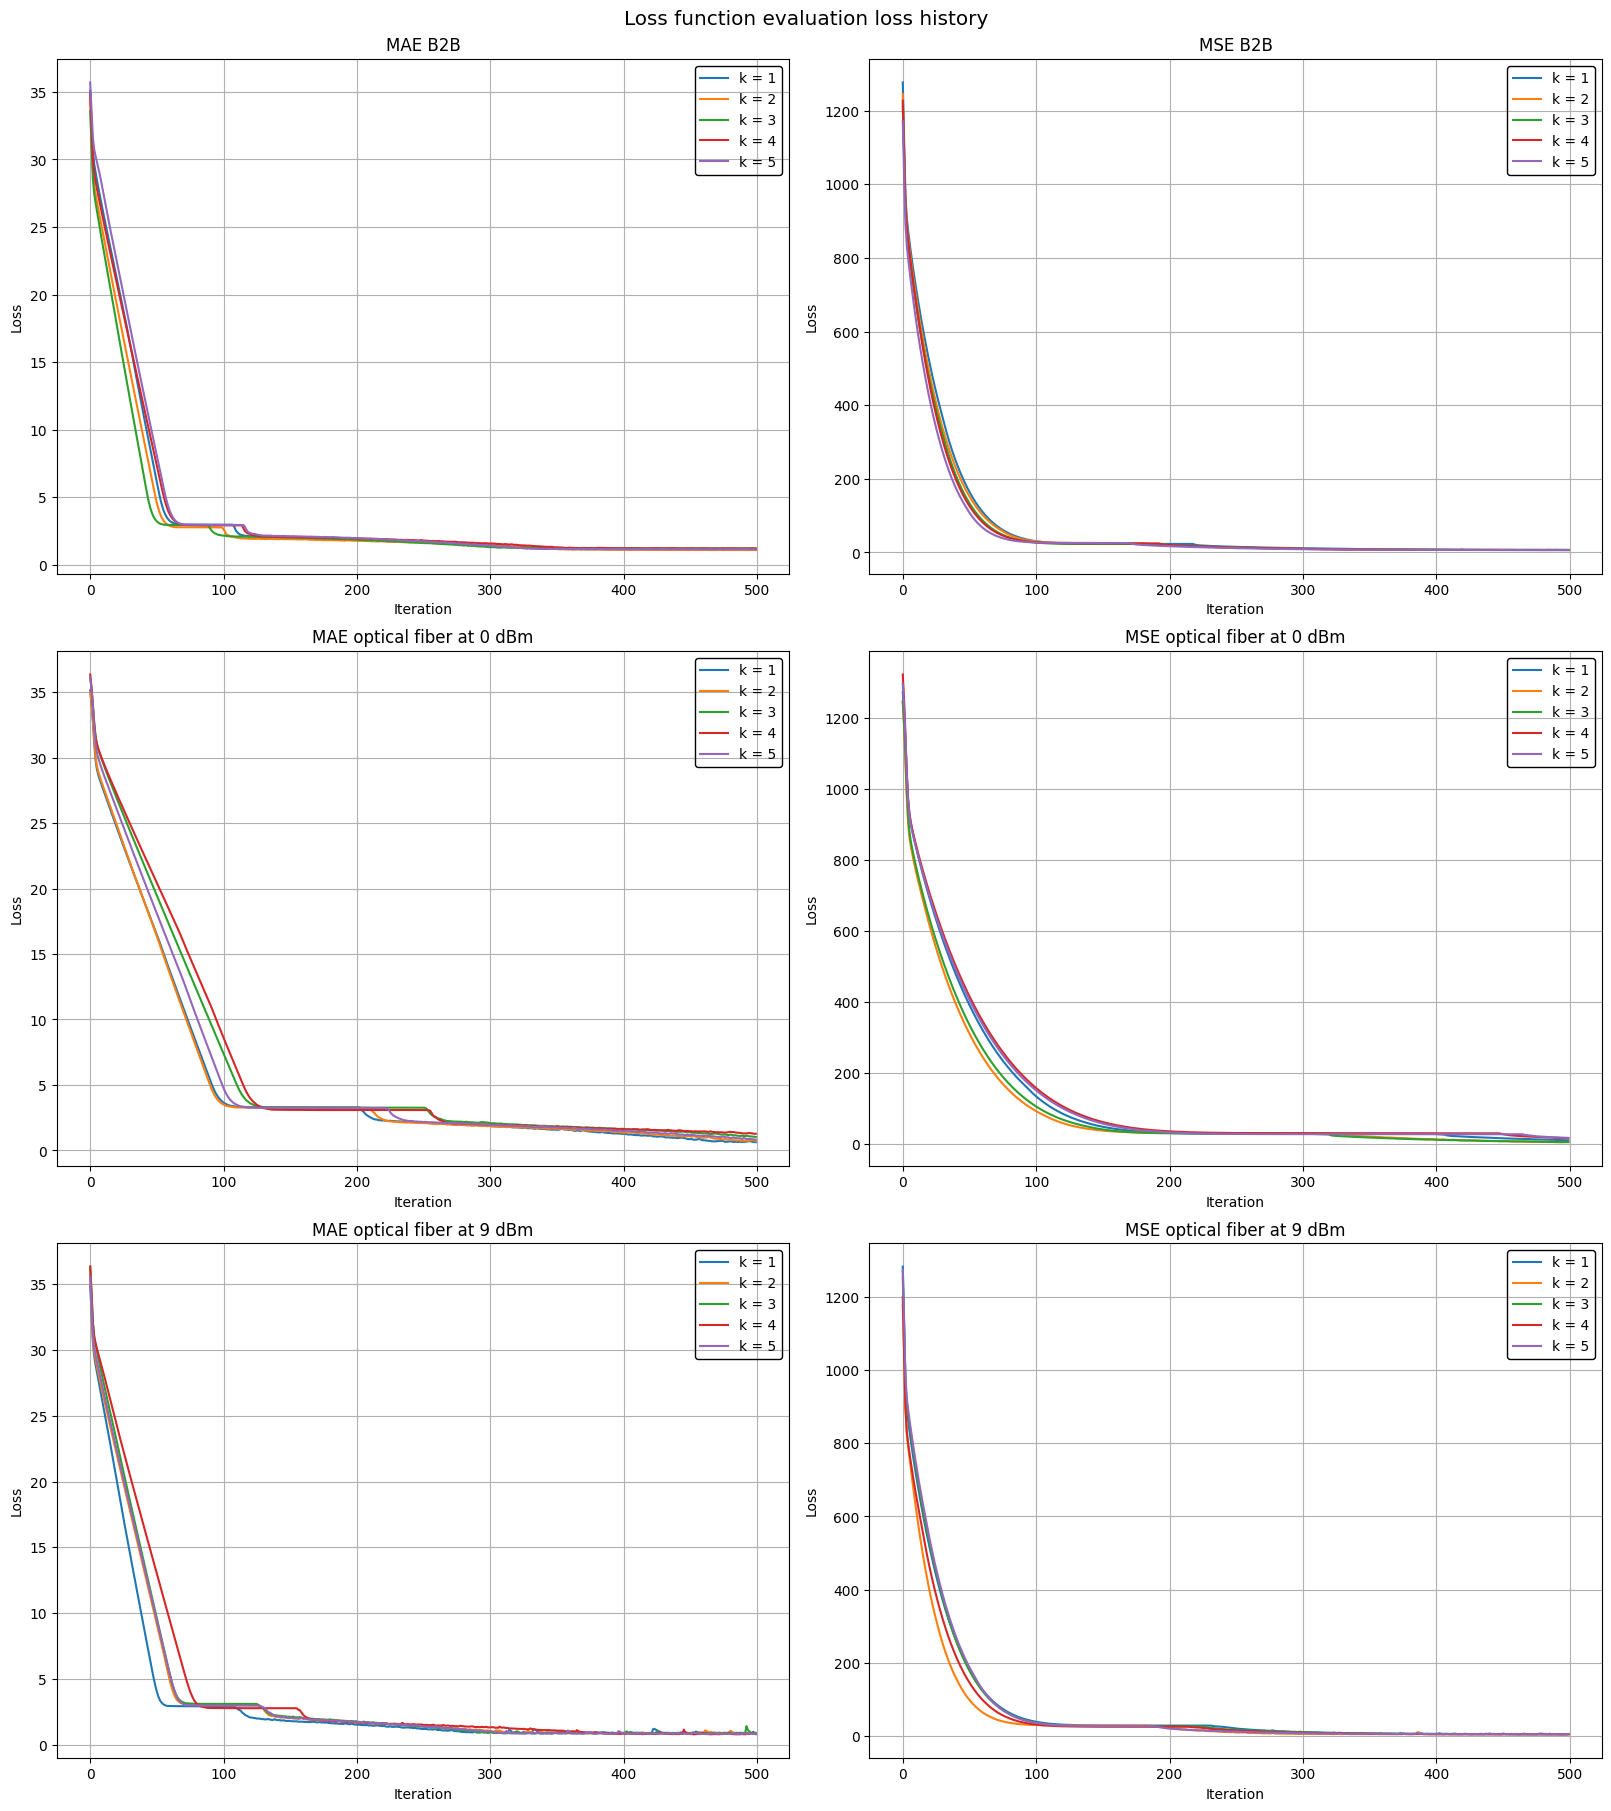

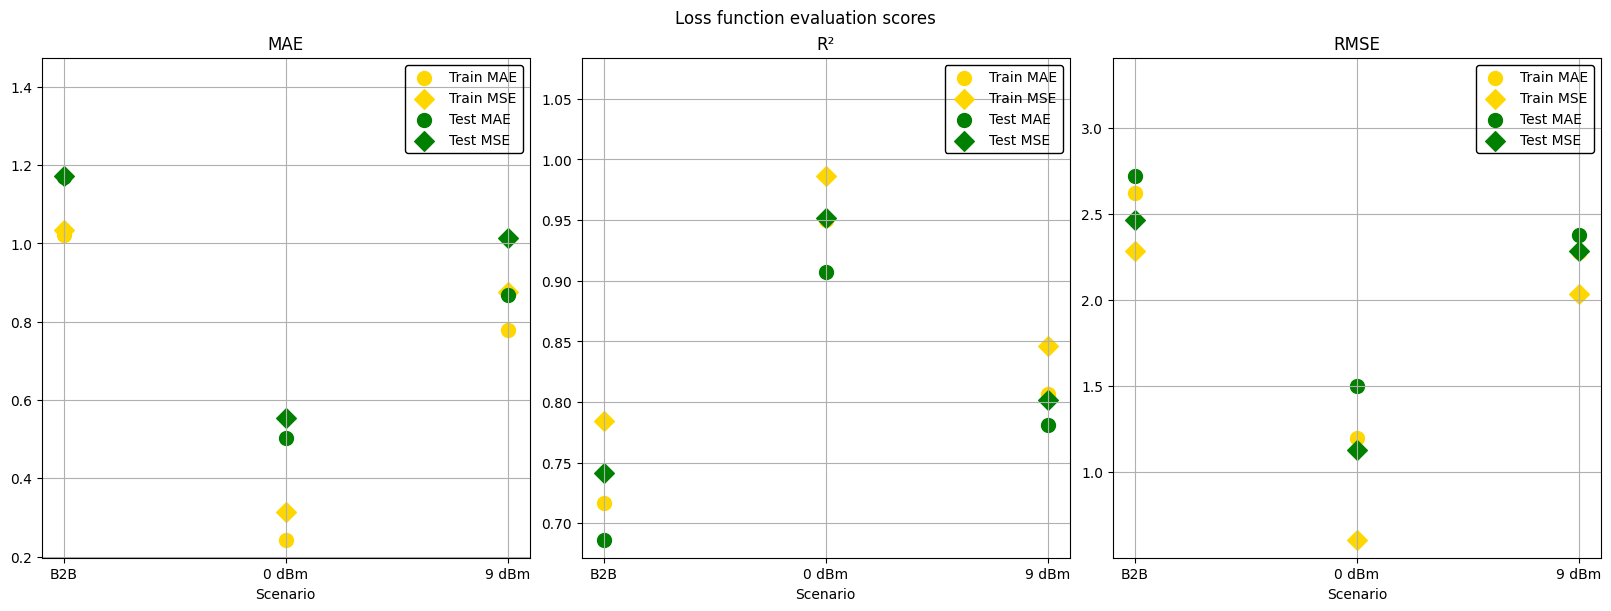

In [130]:
scores = [scores_FCM_MAE_B2B, scores_FCM_MSE_B2B, scores_FCM_MAE_fiber0, scores_FCM_MSE_fiber0, scores_FCM_MAE_fiber9, scores_FCM_MSE_fiber9]
plot_loss_scores(scores, "Loss function evaluation")